In [1]:
import quandl
quandl.ApiConfig.api_key = '1w1X-kbMsxdg4Ts1disD'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
price_table = quandl.get_table('SHARADAR/SEP', 
                               ticker=['BAC', 'C',
                                       'F', 'GM',
                                       'AAPL', 'MSFT', 
                                       'UAL', 'AAL',
                                       'KO', 'PEP',
                                       'XOM', 'CVX',
                                       'SLB', 'HAL',
                                       'FITB', 'KEY',
                                       'GS', 'JPM'
                                      ]
                               , paginate=True)

In [3]:
sorted_table = price_table.sort_values(by=['ticker','date'], ascending=True).copy()
tickers = sorted(list(set(sorted_table['ticker'])))
price_stock = price_table[price_table['ticker']==tickers[0]][['date','close']].sort_values(by='date', ascending=True)
price_stock.reset_index(inplace=True)

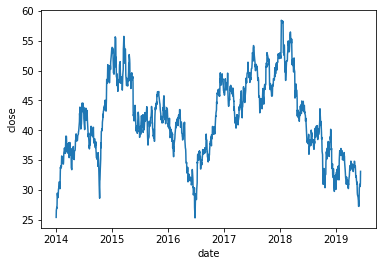

In [4]:
sns.lineplot(x='date', y='close', data=price_stock)

In [5]:
close_df = pd.DataFrame()
close_df['date'] = price_stock['date']
volume_df = pd.DataFrame()
close_df['date'] = price_stock['date']

for ticker in tickers:
    close_df[ticker] = list(sorted_table[sorted_table['ticker']==ticker]['close'])
    volume_ticker = 'v_' + ticker
    volume_df[volume_ticker] = list(sorted_table[sorted_table['ticker']==ticker]['volume'])

no_date_df = close_df[list(close_df.columns)[1:]]
return_df = no_date_df/no_date_df.shift(1) - 1

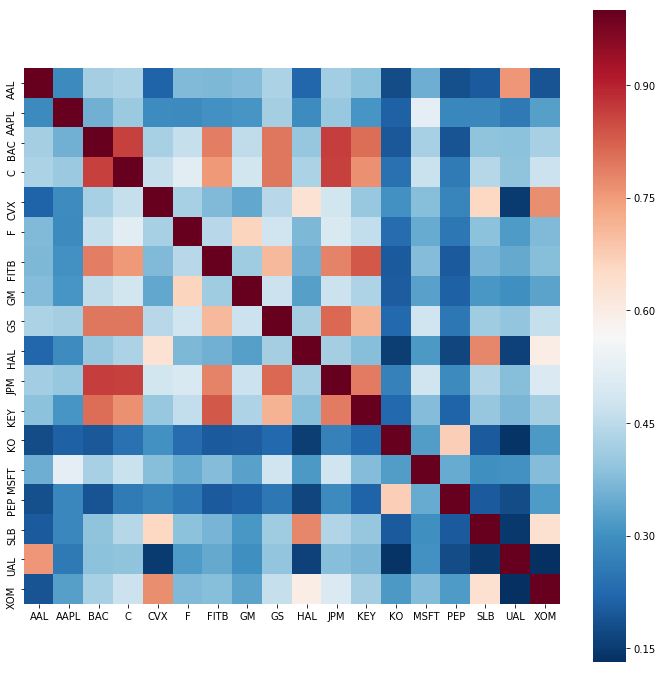

In [6]:
stock_corr = return_df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(stock_corr, square=True, cmap="RdBu_r");

In [186]:
# Helper functions used by primary functions below

def slice_data(train_perc, stocks_to_trade, return_df_2):
    train_len = int(return_df.shape[0] * (train_perc))
    volume_to_trade = ['v_'+ticker for ticker in stocks_to_trade]
    for i in volume_to_trade:
        stocks_to_trade.append(i)

    train = return_df_2[stocks_to_trade][1:train_len].copy()
    train['diff'] = train[stocks_to_trade[0]] - train[stocks_to_trade[1]]
    train.reset_index(inplace=True, drop=True)

    test = return_df_2[stocks_to_trade][train_len:-400].copy()
    test['diff'] = test[stocks_to_trade[0]] - test[stocks_to_trade[1]]
    test.reset_index(inplace=True, drop=True)

    true_test = return_df_2[stocks_to_trade][-400:].copy()
    true_test['diff'] = true_test[stocks_to_trade[0]] - true_test[stocks_to_trade[1]]
    true_test.reset_index(inplace=True, drop=True)

    feature_names = volume_to_trade
    feature_names.append('diff')
    
    return train, test, true_test, feature_names

def make_variables(dataset, lags, look_back, predict_window):
    features = lags+1
    start = look_back
    stop = len(dataset) - lags - predict_window
    
    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, features

In [8]:
# Create and fit the LSTM network

def train_lstm(train, feature_names, lags, look_back, predict_window, lstm_neurons, dense_layers):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    for neurons in dense_layers:
        model.add(Dense(neurons))
        model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='squared_hinge', optimizer='adam')
    model.fit(train_X, train_Y, epochs=250, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [9]:
# Expanding window test where I fit the model to new data each day

def run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window):
    predictions_test = []
    actuals_test = []
    print(expand_set.shape[0] - 1)

    for i in range(0, expand_set.shape[0] - 1):
        print(i)
        curr_row = expand_set[i]
        test_row = expand_set[i+1]
        dataset = np.append(dataset, curr_row, axis=0)
        lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
        train_X = lstm_in_X
        train_Y = lstm_in_Y
    
        # Fit the data all the way up to curr_row (today)
        if i%5 == 0:
            model_test.fit(train_X, train_Y, epochs=10, batch_size=10, verbose=1)
    
        # Predict the next day (out of sample) - data for next day is in test_row
        dataset_test = np.append(dataset, test_row, axis=0)
        lstm_in_X_test, lstm_in_Y_test, features = make_variables(dataset_test, lags, look_back, predict_window)
        test_X = lstm_in_X_test
        pred_Y_test = model_test.predict(test_X)
        predict_test = pred_Y_test[-1,-1]
        actual_test = test_row[-1,-1]
        # Store predictions and actuals to for calculating money made and plotting
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    return predictions_test, actuals_test

In [10]:
def main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers):
    stocks_to_trade = tickers
    return_df_2 = pd.concat([return_df, volume_df], axis=1)
    train, test, true_test, feature_names = slice_data(train_perc, stocks_to_trade, return_df_2)
    expand_set = np.matrix(test[feature_names])
    model_train, dataset, train_X, train_Y, predictions_train, actuals_train = train_lstm(train, feature_names, 
                                                                                          lags, look_back, 
                                                                                          predict_window,
                                                                                          lstm_neurons, dense_layers
                                                                                         )
    model_test = model_train
    predictions_test, actuals_test = run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window)
    
    return model_test, predictions_test, actuals_test, predictions_train, actuals_train

In [11]:
# Main - for running the pipeline

tickers = ['AAPL','MSFT']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_AAPL_MSFT, predictions_test_AAPL_MSFT, actuals_test_AAPL_MSFT, predictions_train_AAPL_MSFT, actuals_train_AAPL_MSFT = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
506/506 [==============================] - 2s 3ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0007
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9990
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9947
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9820
Epoch 7/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9681
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9562
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9450
Epoch 10/250
506/506 [=====

506/506 [==============================] - 1s 2ms/step - loss: 0.7523
Epoch 90/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7525
Epoch 91/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7495
Epoch 92/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7506
Epoch 93/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7457
Epoch 94/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7402
Epoch 95/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7389
Epoch 96/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7382
Epoch 97/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7371
Epoch 98/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7333
Epoch 99/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7325
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7315
Epoch 101/250
50

506/506 [==============================] - 1s 2ms/step - loss: 0.6637
Epoch 187/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6599
Epoch 188/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6556
Epoch 189/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6516
Epoch 190/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6475
Epoch 191/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6508
Epoch 192/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6479
Epoch 193/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6479
Epoch 194/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6447
Epoch 195/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6474
Epoch 196/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6456
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6489
Epoch 

509/509 [==============================] - 1s 2ms/step - loss: 0.6137
Epoch 3/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6085
Epoch 4/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6147
Epoch 5/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6103
Epoch 6/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6111
Epoch 7/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6098
Epoch 8/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6130
Epoch 9/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6200
Epoch 10/10
509/509 [==============================] - 1s 2ms/step - loss: 0.6171
3
Epoch 1/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6156
Epoch 2/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6144
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6128
Epoch 4/10
510/510 [================

519/519 [==============================] - 1s 2ms/step - loss: 0.6059
Epoch 3/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5893
Epoch 4/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5957
Epoch 5/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5940
Epoch 6/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5947
Epoch 7/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5948
Epoch 8/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5890
Epoch 9/10
519/519 [==============================] - 1s 3ms/step - loss: 0.5875
Epoch 10/10
519/519 [==============================] - 1s 2ms/step - loss: 0.5889
13
Epoch 1/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5912
Epoch 2/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6004
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5894
Epoch 4/10
520/520 [===============

529/529 [==============================] - 1s 2ms/step - loss: 0.5769
Epoch 3/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5785
Epoch 4/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5709
Epoch 5/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5723
Epoch 6/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5693
Epoch 7/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5679
Epoch 8/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5698
Epoch 9/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5764
Epoch 10/10
529/529 [==============================] - 1s 2ms/step - loss: 0.5699
23
Epoch 1/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5741
Epoch 2/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5788
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5809
Epoch 4/10
530/530 [===============

539/539 [==============================] - 1s 2ms/step - loss: 0.5593
Epoch 3/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5630
Epoch 4/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5628
Epoch 5/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5657
Epoch 6/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5521
Epoch 7/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5673
Epoch 8/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5561
Epoch 9/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5614
Epoch 10/10
539/539 [==============================] - 1s 2ms/step - loss: 0.5611
33
Epoch 1/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5587
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5574
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5596
Epoch 4/10
540/540 [===============

549/549 [==============================] - 1s 2ms/step - loss: 0.5475
Epoch 3/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5569
Epoch 4/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5471
Epoch 5/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5488
Epoch 6/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5425
Epoch 7/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5470
Epoch 8/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5396
Epoch 9/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5417
Epoch 10/10
549/549 [==============================] - 1s 2ms/step - loss: 0.5448
43
Epoch 1/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5438
Epoch 2/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5433
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5408
Epoch 4/10
550/550 [===============

559/559 [==============================] - 1s 2ms/step - loss: 0.5243
Epoch 3/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5198
Epoch 4/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5201
Epoch 5/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5244
Epoch 6/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5187
Epoch 7/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5275
Epoch 8/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5211
Epoch 9/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5203
Epoch 10/10
559/559 [==============================] - 1s 2ms/step - loss: 0.5215
53
Epoch 1/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5273
Epoch 2/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5185
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5128
Epoch 4/10
560/560 [===============

569/569 [==============================] - 1s 2ms/step - loss: 0.4856
Epoch 3/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4823
Epoch 4/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4842
Epoch 5/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4819
Epoch 6/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4785
Epoch 7/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4795
Epoch 8/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4780
Epoch 9/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4831
Epoch 10/10
569/569 [==============================] - 1s 2ms/step - loss: 0.4811
63
Epoch 1/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4895
Epoch 2/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4859
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4775
Epoch 4/10
570/570 [===============

579/579 [==============================] - 1s 2ms/step - loss: 0.4499
Epoch 3/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4485
Epoch 4/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4502
Epoch 5/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4629
Epoch 6/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4480
Epoch 7/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4411
Epoch 8/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4431
Epoch 9/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4493
Epoch 10/10
579/579 [==============================] - 1s 2ms/step - loss: 0.4474
73
Epoch 1/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4427
Epoch 2/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4450
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4377
Epoch 4/10
580/580 [===============

589/589 [==============================] - 1s 2ms/step - loss: 0.4004
Epoch 3/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4043
Epoch 4/10
589/589 [==============================] - 1s 2ms/step - loss: 0.3999
Epoch 5/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4244
Epoch 6/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4825
Epoch 7/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4210
Epoch 8/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4028
Epoch 9/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4105
Epoch 10/10
589/589 [==============================] - 1s 2ms/step - loss: 0.4013
83
Epoch 1/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4024
Epoch 2/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4008
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.3978
Epoch 4/10
590/590 [===============

599/599 [==============================] - 1s 2ms/step - loss: 0.4265
Epoch 3/10
599/599 [==============================] - 1s 2ms/step - loss: 0.4092
Epoch 4/10
599/599 [==============================] - 1s 2ms/step - loss: 0.4019
Epoch 5/10
599/599 [==============================] - 1s 2ms/step - loss: 0.3989
Epoch 6/10
599/599 [==============================] - 1s 2ms/step - loss: 0.3901
Epoch 7/10
599/599 [==============================] - 1s 2ms/step - loss: 0.3912
Epoch 8/10
599/599 [==============================] - 1s 2ms/step - loss: 0.3932
Epoch 9/10
599/599 [==============================] - 1s 2ms/step - loss: 0.3859
Epoch 10/10
599/599 [==============================] - 1s 2ms/step - loss: 0.3821
93
Epoch 1/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3913
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3878
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3813
Epoch 4/10
600/600 [===============

609/609 [==============================] - 1s 2ms/step - loss: 0.3407
Epoch 3/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3448
Epoch 4/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3415
Epoch 5/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3404
Epoch 6/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3396
Epoch 7/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3357
Epoch 8/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3425
Epoch 9/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3334
Epoch 10/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3397
103
Epoch 1/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3296
Epoch 2/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3500
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3460
Epoch 4/10
610/610 [==============

619/619 [==============================] - 1s 2ms/step - loss: 0.3278
Epoch 3/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3337
Epoch 4/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3272
Epoch 5/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3123
Epoch 6/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3624
Epoch 7/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3337
Epoch 8/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3317
Epoch 9/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3276
Epoch 10/10
619/619 [==============================] - 1s 2ms/step - loss: 0.3209
113
Epoch 1/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3245
Epoch 2/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3234
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3259
Epoch 4/10
620/620 [==============

629/629 [==============================] - 1s 2ms/step - loss: 0.3174
Epoch 3/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3109
Epoch 4/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3071
Epoch 5/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3158
Epoch 6/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3070
Epoch 7/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3086
Epoch 8/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3179
Epoch 9/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3143
Epoch 10/10
629/629 [==============================] - 1s 2ms/step - loss: 0.3090
123
Epoch 1/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3062
Epoch 2/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3095
Epoch 3/10
630/630 [==============================] - 14s 22ms/step - loss: 0.3114
Epoch 4/10
630/630 [============

639/639 [==============================] - 2s 2ms/step - loss: 0.2957
Epoch 3/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2983
Epoch 4/10
639/639 [==============================] - 1s 2ms/step - loss: 0.3197
Epoch 5/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2924
Epoch 6/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2928
Epoch 7/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2965
Epoch 8/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2873
Epoch 9/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2864
Epoch 10/10
639/639 [==============================] - 1s 2ms/step - loss: 0.2757
133
Epoch 1/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3879
Epoch 2/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3208
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2917
Epoch 4/10
640/640 [==============

649/649 [==============================] - 1s 2ms/step - loss: 0.2769
Epoch 3/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2756
Epoch 4/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2734
Epoch 5/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2687
Epoch 6/10
649/649 [==============================] - 1s 2ms/step - loss: 0.3035
Epoch 7/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2834
Epoch 8/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2776
Epoch 9/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2782
Epoch 10/10
649/649 [==============================] - 1s 2ms/step - loss: 0.2800
143
Epoch 1/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2951
Epoch 2/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2970
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2821
Epoch 4/10
650/650 [==============

659/659 [==============================] - 1s 2ms/step - loss: 0.4246
Epoch 3/10
659/659 [==============================] - 1s 2ms/step - loss: 0.3349
Epoch 4/10
659/659 [==============================] - 1s 2ms/step - loss: 0.3272
Epoch 5/10
659/659 [==============================] - 1s 2ms/step - loss: 0.3063
Epoch 6/10
659/659 [==============================] - 1s 2ms/step - loss: 0.3415
Epoch 7/10
659/659 [==============================] - 1s 2ms/step - loss: 0.2879
Epoch 8/10
659/659 [==============================] - 1s 2ms/step - loss: 0.2788
Epoch 9/10
659/659 [==============================] - 1s 2ms/step - loss: 0.2801
Epoch 10/10
659/659 [==============================] - 1s 2ms/step - loss: 0.2660
153
Epoch 1/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2712
Epoch 2/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2656
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2668
Epoch 4/10
660/660 [==============

669/669 [==============================] - 1s 2ms/step - loss: 0.2758
Epoch 3/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2718
Epoch 4/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2626
Epoch 5/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2620
Epoch 6/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2560
Epoch 7/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2603
Epoch 8/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2575
Epoch 9/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2779
Epoch 10/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2981
163
Epoch 1/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2759
Epoch 2/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2745
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2687
Epoch 4/10
670/670 [==============

679/679 [==============================] - 1s 2ms/step - loss: 0.2483
Epoch 3/10
679/679 [==============================] - 1s 2ms/step - loss: 0.2478
Epoch 4/10
679/679 [==============================] - 1s 2ms/step - loss: 0.2447
Epoch 5/10
679/679 [==============================] - 1s 2ms/step - loss: 0.3386
Epoch 6/10
679/679 [==============================] - 1s 2ms/step - loss: 0.3397
Epoch 7/10
679/679 [==============================] - 1s 2ms/step - loss: 0.3447
Epoch 8/10
679/679 [==============================] - 1s 2ms/step - loss: 0.3072
Epoch 9/10
679/679 [==============================] - 1s 2ms/step - loss: 0.2744
Epoch 10/10
679/679 [==============================] - 1s 2ms/step - loss: 0.2621
173
Epoch 1/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2551
Epoch 2/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2670
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2613
Epoch 4/10
680/680 [==============

689/689 [==============================] - 1s 2ms/step - loss: 0.2551
Epoch 3/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2596
Epoch 4/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2531
Epoch 5/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2505
Epoch 6/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2448
Epoch 7/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2431
Epoch 8/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2358
Epoch 9/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2380
Epoch 10/10
689/689 [==============================] - 1s 2ms/step - loss: 0.2437
183
Epoch 1/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2518
Epoch 2/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2536
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2583
Epoch 4/10
690/690 [==============

699/699 [==============================] - 1s 2ms/step - loss: 0.2436
Epoch 3/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2403
Epoch 4/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2474
Epoch 5/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2453
Epoch 6/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2370
Epoch 7/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2366
Epoch 8/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2473
Epoch 9/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2668
Epoch 10/10
699/699 [==============================] - 1s 2ms/step - loss: 0.2822
193
Epoch 1/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2520
Epoch 2/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2528
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3091
Epoch 4/10
700/700 [==============

709/709 [==============================] - 1s 2ms/step - loss: 0.2321
Epoch 3/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2422
Epoch 4/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2296
Epoch 5/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2380
Epoch 6/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2311
Epoch 7/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2432
Epoch 8/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2299
Epoch 9/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2302
Epoch 10/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2276
203
Epoch 1/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2495
Epoch 2/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2518
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2813
Epoch 4/10
710/710 [==============

719/719 [==============================] - 1s 2ms/step - loss: 0.2536
Epoch 3/10
719/719 [==============================] - 1s 2ms/step - loss: 0.2449
Epoch 4/10
719/719 [==============================] - 1s 2ms/step - loss: 0.2588
Epoch 5/10
719/719 [==============================] - 79s 110ms/step - loss: 0.2734
Epoch 6/10
719/719 [==============================] - 1s 2ms/step - loss: 0.2671
Epoch 7/10
719/719 [==============================] - 1s 2ms/step - loss: 0.2527
Epoch 8/10
719/719 [==============================] - 2s 2ms/step - loss: 0.2368
Epoch 9/10
719/719 [==============================] - 2s 2ms/step - loss: 0.2426
Epoch 10/10
719/719 [==============================] - 1s 2ms/step - loss: 0.2267
213
Epoch 1/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2323
Epoch 2/10
720/720 [==============================] - 5s 7ms/step - loss: 0.2444
Epoch 3/10
720/720 [==============================] - 8s 11ms/step - loss: 0.2308
Epoch 4/10
720/720 [==========

729/729 [==============================] - 1s 2ms/step - loss: 0.2438
Epoch 3/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2367
Epoch 4/10
729/729 [==============================] - 1s 2ms/step - loss: 0.3071
Epoch 5/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2936
Epoch 6/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2752
Epoch 7/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2639
Epoch 8/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2366
Epoch 9/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2337
Epoch 10/10
729/729 [==============================] - 1s 2ms/step - loss: 0.2372
223
Epoch 1/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2307
Epoch 2/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2343
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2389
Epoch 4/10
730/730 [==============

739/739 [==============================] - 1s 2ms/step - loss: 0.3891
Epoch 3/10
739/739 [==============================] - 1s 2ms/step - loss: 0.3262
Epoch 4/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2978
Epoch 5/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2814
Epoch 6/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2721
Epoch 7/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2778
Epoch 8/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2578
Epoch 9/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2577
Epoch 10/10
739/739 [==============================] - 1s 2ms/step - loss: 0.2502
233
Epoch 1/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2446
Epoch 2/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2503
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2353
Epoch 4/10
740/740 [==============

749/749 [==============================] - 1s 2ms/step - loss: 0.2362
Epoch 3/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2483
Epoch 4/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2422
Epoch 5/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2303
Epoch 6/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2447
Epoch 7/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2637
Epoch 8/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2664
Epoch 9/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2683
Epoch 10/10
749/749 [==============================] - 1s 2ms/step - loss: 0.2620
243
Epoch 1/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2454
Epoch 2/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2315
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2531
Epoch 4/10
750/750 [==============

759/759 [==============================] - 1s 2ms/step - loss: 0.5526
Epoch 3/10
759/759 [==============================] - 1s 2ms/step - loss: 0.3787
Epoch 4/10
759/759 [==============================] - 1s 2ms/step - loss: 0.3031
Epoch 5/10
759/759 [==============================] - 1s 2ms/step - loss: 0.2663
Epoch 6/10
759/759 [==============================] - 1s 2ms/step - loss: 0.2543
Epoch 7/10
759/759 [==============================] - 1s 2ms/step - loss: 0.2427
Epoch 8/10
759/759 [==============================] - 1s 2ms/step - loss: 0.2510
Epoch 9/10
759/759 [==============================] - 1s 2ms/step - loss: 0.2380
Epoch 10/10
759/759 [==============================] - 1s 2ms/step - loss: 0.2232
253
Epoch 1/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2255
Epoch 2/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2302
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2297
Epoch 4/10
760/760 [==============

769/769 [==============================] - 1s 2ms/step - loss: 0.2238
Epoch 3/10
769/769 [==============================] - 1s 2ms/step - loss: 0.2315
Epoch 4/10
769/769 [==============================] - 1s 2ms/step - loss: 0.2204
Epoch 5/10
769/769 [==============================] - 1s 2ms/step - loss: 0.2291
Epoch 6/10
769/769 [==============================] - 1s 2ms/step - loss: 0.4880
Epoch 7/10
769/769 [==============================] - 1s 2ms/step - loss: 0.4235
Epoch 8/10
769/769 [==============================] - 1s 2ms/step - loss: 0.3131
Epoch 9/10
769/769 [==============================] - 1s 2ms/step - loss: 0.3415
Epoch 10/10
769/769 [==============================] - 1s 2ms/step - loss: 0.2895
263
Epoch 1/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2875
Epoch 2/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2452
Epoch 3/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2405
Epoch 4/10
770/770 [==============

779/779 [==============================] - 1s 2ms/step - loss: 0.2497
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.2472
Epoch 4/10
779/779 [==============================] - 1s 2ms/step - loss: 0.2428
Epoch 5/10
779/779 [==============================] - 1s 2ms/step - loss: 0.2500
Epoch 6/10
779/779 [==============================] - 1s 2ms/step - loss: 0.3265
Epoch 7/10
779/779 [==============================] - 1s 2ms/step - loss: 0.2988
Epoch 8/10
779/779 [==============================] - 1s 2ms/step - loss: 0.2685
Epoch 9/10
779/779 [==============================] - 1s 2ms/step - loss: 0.2506
Epoch 10/10
779/779 [==============================] - 1s 2ms/step - loss: 0.2430
273
Epoch 1/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2483
Epoch 2/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2358
Epoch 3/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2399
Epoch 4/10
780/780 [==============

789/789 [==============================] - 1s 2ms/step - loss: 0.2246
Epoch 3/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2267
Epoch 4/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2652
Epoch 5/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2422
Epoch 6/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2493
Epoch 7/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2197
Epoch 8/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2287
Epoch 9/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2258
Epoch 10/10
789/789 [==============================] - 1s 2ms/step - loss: 0.2255
283
Epoch 1/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2221
Epoch 2/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2253
Epoch 3/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2237
Epoch 4/10
790/790 [==============

799/799 [==============================] - 1s 2ms/step - loss: 0.2311
Epoch 3/10
799/799 [==============================] - 1s 2ms/step - loss: 0.2124
Epoch 4/10
799/799 [==============================] - 1s 2ms/step - loss: 0.2137
Epoch 5/10
799/799 [==============================] - 2s 2ms/step - loss: 0.2122
Epoch 6/10
799/799 [==============================] - 1s 2ms/step - loss: 0.2099
Epoch 7/10
799/799 [==============================] - 1s 2ms/step - loss: 0.2159
Epoch 8/10
799/799 [==============================] - 2s 2ms/step - loss: 0.3019
Epoch 9/10
799/799 [==============================] - 1s 2ms/step - loss: 0.2669
Epoch 10/10
799/799 [==============================] - 2s 2ms/step - loss: 0.2552
293
Epoch 1/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2412
Epoch 2/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2369
Epoch 3/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2225
Epoch 4/10
800/800 [==============

809/809 [==============================] - 1s 2ms/step - loss: 0.2173
Epoch 3/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2312
Epoch 4/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2194
Epoch 5/10
809/809 [==============================] - 2s 2ms/step - loss: 0.2141
Epoch 6/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2145
Epoch 7/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2650
Epoch 8/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2445
Epoch 9/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2387
Epoch 10/10
809/809 [==============================] - 1s 2ms/step - loss: 0.2229
303
Epoch 1/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2328
Epoch 2/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2469
Epoch 3/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2207
Epoch 4/10
810/810 [==============

819/819 [==============================] - 1s 2ms/step - loss: 0.3546
Epoch 3/10
819/819 [==============================] - 1s 2ms/step - loss: 0.3907
Epoch 4/10
819/819 [==============================] - 1s 2ms/step - loss: 0.2750
Epoch 5/10
819/819 [==============================] - 1s 2ms/step - loss: 0.2392
Epoch 6/10
819/819 [==============================] - 1s 2ms/step - loss: 0.2262
Epoch 7/10
819/819 [==============================] - 1s 2ms/step - loss: 0.2280
Epoch 8/10
819/819 [==============================] - 1s 2ms/step - loss: 0.2147
Epoch 9/10
819/819 [==============================] - 2s 2ms/step - loss: 0.2209
Epoch 10/10
819/819 [==============================] - 1s 2ms/step - loss: 0.2371
313
Epoch 1/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2277
Epoch 2/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2181
Epoch 3/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2115
Epoch 4/10
820/820 [==============

829/829 [==============================] - 1s 2ms/step - loss: 0.3063
Epoch 3/10
829/829 [==============================] - 1s 2ms/step - loss: 0.2944
Epoch 4/10
829/829 [==============================] - 2s 2ms/step - loss: 0.2352
Epoch 5/10
829/829 [==============================] - 2s 2ms/step - loss: 0.2261
Epoch 6/10
829/829 [==============================] - 1s 2ms/step - loss: 0.2301
Epoch 7/10
829/829 [==============================] - 1s 2ms/step - loss: 0.2293
Epoch 8/10
829/829 [==============================] - 2s 2ms/step - loss: 0.2571
Epoch 9/10
829/829 [==============================] - 2s 2ms/step - loss: 0.2691
Epoch 10/10
829/829 [==============================] - 2s 2ms/step - loss: 0.3371
323
Epoch 1/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2562
Epoch 2/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2473
Epoch 3/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2152
Epoch 4/10
830/830 [==============

839/839 [==============================] - 2s 2ms/step - loss: 0.2205
Epoch 3/10
839/839 [==============================] - 1s 2ms/step - loss: 0.2261
Epoch 4/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2225
Epoch 5/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2406
Epoch 6/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2503
Epoch 7/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2436
Epoch 8/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2588
Epoch 9/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2453
Epoch 10/10
839/839 [==============================] - 2s 2ms/step - loss: 0.2986
333
Epoch 1/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2288
Epoch 2/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2201
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2202
Epoch 4/10
840/840 [==============

849/849 [==============================] - 2s 2ms/step - loss: 0.2037
Epoch 3/10
849/849 [==============================] - 1s 2ms/step - loss: 0.2028
Epoch 4/10
849/849 [==============================] - 2s 2ms/step - loss: 0.1937
Epoch 5/10
849/849 [==============================] - 2s 2ms/step - loss: 0.2122
Epoch 6/10
849/849 [==============================] - 2s 2ms/step - loss: 0.2777
Epoch 7/10
849/849 [==============================] - 2s 2ms/step - loss: 0.2501
Epoch 8/10
849/849 [==============================] - 2s 2ms/step - loss: 0.2154
Epoch 9/10
849/849 [==============================] - 2s 2ms/step - loss: 0.2112
Epoch 10/10
849/849 [==============================] - 2s 2ms/step - loss: 0.2207
343
Epoch 1/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2067
Epoch 2/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2118
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2135
Epoch 4/10
850/850 [==============

859/859 [==============================] - 2s 2ms/step - loss: 0.2092
Epoch 3/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2120
Epoch 4/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2118
Epoch 5/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2253
Epoch 6/10
859/859 [==============================] - 2s 2ms/step - loss: 0.4381
Epoch 7/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2984
Epoch 8/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2682
Epoch 9/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2580
Epoch 10/10
859/859 [==============================] - 2s 2ms/step - loss: 0.2664
353
Epoch 1/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2405
Epoch 2/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2221
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2584
Epoch 4/10
860/860 [==============

869/869 [==============================] - 2s 2ms/step - loss: 0.2123
Epoch 3/10
869/869 [==============================] - 2s 2ms/step - loss: 0.2107
Epoch 4/10
869/869 [==============================] - 1s 2ms/step - loss: 0.1978
Epoch 5/10
869/869 [==============================] - 2s 2ms/step - loss: 0.2065
Epoch 6/10
869/869 [==============================] - 2s 2ms/step - loss: 0.2103
Epoch 7/10
869/869 [==============================] - 2s 2ms/step - loss: 0.1940
Epoch 8/10
869/869 [==============================] - 2s 2ms/step - loss: 0.1979
Epoch 9/10
869/869 [==============================] - 2s 2ms/step - loss: 0.2046
Epoch 10/10
869/869 [==============================] - 1s 2ms/step - loss: 0.1955
363
Epoch 1/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2440
Epoch 2/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2055
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2003
Epoch 4/10
870/870 [==============

879/879 [==============================] - 2s 2ms/step - loss: 0.2957
Epoch 3/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2483
Epoch 4/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2863
Epoch 5/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2383
Epoch 6/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 7/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2290
Epoch 8/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2069
Epoch 9/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2283
Epoch 10/10
879/879 [==============================] - 2s 2ms/step - loss: 0.2108
373
Epoch 1/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2170
Epoch 2/10
880/880 [==============================] - 1s 2ms/step - loss: 0.2186
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2392
Epoch 4/10
880/880 [==============

889/889 [==============================] - 1s 2ms/step - loss: 0.2229
Epoch 3/10
889/889 [==============================] - 2s 2ms/step - loss: 0.2265
Epoch 4/10
889/889 [==============================] - 2s 2ms/step - loss: 0.2088
Epoch 5/10
889/889 [==============================] - 2s 2ms/step - loss: 0.2086
Epoch 6/10
889/889 [==============================] - 2s 2ms/step - loss: 0.2023
Epoch 7/10
889/889 [==============================] - 2s 2ms/step - loss: 0.2011
Epoch 8/10
889/889 [==============================] - 2s 2ms/step - loss: 0.1911
Epoch 9/10
889/889 [==============================] - 2s 2ms/step - loss: 0.1988
Epoch 10/10
889/889 [==============================] - 2s 2ms/step - loss: 0.1906
383
Epoch 1/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2082
Epoch 2/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2132
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2202
Epoch 4/10
890/890 [==============

899/899 [==============================] - 2s 2ms/step - loss: 0.2235
Epoch 3/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2138
Epoch 4/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2132
Epoch 5/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2043
Epoch 6/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2038
Epoch 7/10
899/899 [==============================] - 2s 2ms/step - loss: 0.1983
Epoch 8/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2016
Epoch 9/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2064
Epoch 10/10
899/899 [==============================] - 2s 2ms/step - loss: 0.2032
393
Epoch 1/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2043
Epoch 2/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2050
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2314
Epoch 4/10
900/900 [==============

909/909 [==============================] - 2s 2ms/step - loss: 0.2043
Epoch 3/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2069
Epoch 4/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2009
Epoch 5/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2003
Epoch 6/10
909/909 [==============================] - 2s 2ms/step - loss: 0.1984
Epoch 7/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2895
Epoch 8/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2871
Epoch 9/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2357
Epoch 10/10
909/909 [==============================] - 2s 2ms/step - loss: 0.2199
403
Epoch 1/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2210
Epoch 2/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2146
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2091
Epoch 4/10
910/910 [==============

919/919 [==============================] - 2s 2ms/step - loss: 0.1998
Epoch 3/10
919/919 [==============================] - 2s 2ms/step - loss: 0.2006
Epoch 4/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1989
Epoch 5/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1950
Epoch 6/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1932
Epoch 7/10
919/919 [==============================] - 2s 2ms/step - loss: 0.2081
Epoch 8/10
919/919 [==============================] - 2s 2ms/step - loss: 0.2160
Epoch 9/10
919/919 [==============================] - 2s 2ms/step - loss: 0.2050
Epoch 10/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1965
413
Epoch 1/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2127
Epoch 2/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2237
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2106
Epoch 4/10
920/920 [==============

In [13]:
# Main - for running the pipeline

tickers = ['GS','JPM']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_GS_JPM, predictions_test_GS_JPM, actuals_test_GS_JPM, predictions_train_GS_JPM, actuals_train_GS_JPM = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9998
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9998
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9993
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0001
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0009
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8735
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8698
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8705
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8708
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8689
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8673
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8736
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8651
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8654
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8671
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8656
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8659
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7760
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7757
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7802
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7767
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7701
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7716
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7727
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7709
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7683
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7678
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7687
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7695
Epoch 

510/510 [==============================] - 1s 2ms/step - loss: 0.7145
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7069
Epoch 4/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7087
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7119
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7109
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7068
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7078
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7076
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7076
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7125
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7079
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7087
Epoch 4/10
511/511 [================

520/520 [==============================] - 1s 2ms/step - loss: 0.6594
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6599
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6578
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6548
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6543
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6527
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6553
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6633
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6558
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6543
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6547
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6531
Epoch 4/10
521/521 [===============

530/530 [==============================] - 1s 2ms/step - loss: 0.6208
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6255
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6217
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6221
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6218
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6177
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6197
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6252
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6191
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6144
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6226
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6214
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.6018
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5921
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5957
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5987
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5987
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6020
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5949
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5944
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5975
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5936
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5968
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5954
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.5801
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5775
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5790
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5765
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5723
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5804
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5821
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5811
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5772
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5758
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5745
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5780
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.5512
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5543
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5513
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5582
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5610
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5619
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5520
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5554
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5520
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5564
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5518
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5538
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.5226
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5260
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5250
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5219
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5254
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5227
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5157
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5214
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5255
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5179
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5301
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5239
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.4902
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4919
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4906
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4870
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4841
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4826
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4904
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4835
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4980
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4986
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4986
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4888
Epoch 4/10
581/581 [===============

590/590 [==============================] - 1s 2ms/step - loss: 0.4620
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5128
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4781
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4628
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4627
Epoch 7/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4637
Epoch 8/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4569
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4543
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4551
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4607
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4564
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4678
Epoch 4/10
591/591 [===============

600/600 [==============================] - 1s 2ms/step - loss: 0.4433
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4335
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4384
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4459
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4441
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4456
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4369
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4333
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4368
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4341
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4371
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4387
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.4182
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4067
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4210
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4125
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4087
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4095
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4071
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4364
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4349
104
Epoch 1/10
611/611 [==============================] - 2s 3ms/step - loss: 0.4155
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4087
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4717
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.4011
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4051
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3884
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3895
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3861
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3918
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4001
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3974
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3995
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.4178
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.5272
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 1.0917
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.3673
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3718
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3701
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3709
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3628
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3746
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3717
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3603
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3698
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3668
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3735
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3958
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.3468
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3558
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3485
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3610
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3484
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3444
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3421
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3477
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3371
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3501
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3775
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3492
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.3460
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3284
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3313
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3230
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3218
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3216
Epoch 8/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3223
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3199
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3200
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3432
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3236
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3281
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.3097
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3071
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3121
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3108
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3141
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3574
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3325
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3120
Epoch 10/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3092
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3029
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3186
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3294
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.2974
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3077
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3140
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3049
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3115
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3081
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2992
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2993
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2956
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3015
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3068
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3160
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.2768
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2815
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2819
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2842
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2970
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2950
Epoch 8/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3083
Epoch 9/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3231
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3880
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.7889
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.6090
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.4396
Epoch 4/10
681/681 [==============

690/690 [==============================] - 1s 2ms/step - loss: 0.2798
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2726
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2913
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2783
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2733
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2715
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2701
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2823
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2805
184
Epoch 1/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2761
Epoch 2/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2855
Epoch 3/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2921
Epoch 4/10
691/691 [==============

700/700 [==============================] - 1s 2ms/step - loss: 0.5721
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3973
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3135
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2830
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2825
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2732
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2696
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2653
Epoch 10/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2647
194
Epoch 1/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2732
Epoch 2/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2610
Epoch 3/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2582
Epoch 4/10
701/701 [==============

710/710 [==============================] - 1s 2ms/step - loss: 0.2971
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2659
Epoch 4/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2720
Epoch 5/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2591
Epoch 6/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2557
Epoch 7/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2728
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2899
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3302
Epoch 10/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2863
204
Epoch 1/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2609
Epoch 2/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2594
Epoch 3/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2629
Epoch 4/10
711/711 [==============

720/720 [==============================] - 1s 2ms/step - loss: 0.2448
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2497
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2524
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2422
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2422
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2399
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2524
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2502
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2559
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2566
Epoch 2/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2647
Epoch 3/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2575
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.2469
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2544
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2497
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3180
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3678
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3201
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2725
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2810
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2485
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2544
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2659
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2499
Epoch 4/10
731/731 [==============

740/740 [==============================] - 1s 2ms/step - loss: 0.4775
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.4029
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3145
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3045
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2589
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2453
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2502
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2446
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2360
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2315
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2392
Epoch 3/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2387
Epoch 4/10
741/741 [==============

750/750 [==============================] - 2s 2ms/step - loss: 0.2579
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2583
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2545
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2505
Epoch 6/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2499
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2495
Epoch 8/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2426
Epoch 9/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2478
Epoch 10/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2381
244
Epoch 1/10
751/751 [==============================] - 1s 2ms/step - loss: 0.5211
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3447
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2860
Epoch 4/10
751/751 [==============

760/760 [==============================] - 1s 2ms/step - loss: 0.2475
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2397
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2408
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2389
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2262
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2292
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2185
Epoch 9/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2183
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2246
254
Epoch 1/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2308
Epoch 2/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2299
Epoch 3/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2337
Epoch 4/10
761/761 [==============

770/770 [==============================] - 1s 2ms/step - loss: 0.3243
Epoch 3/10
770/770 [==============================] - 1s 2ms/step - loss: 0.8712
Epoch 4/10
770/770 [==============================] - 1s 2ms/step - loss: 0.5503
Epoch 5/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3471
Epoch 6/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2874
Epoch 7/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2516
Epoch 8/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2597
Epoch 9/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2528
Epoch 10/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2430
264
Epoch 1/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2412
Epoch 2/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2371
Epoch 3/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2440
Epoch 4/10
771/771 [==============

780/780 [==============================] - 1s 2ms/step - loss: 0.3055
Epoch 3/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2745
Epoch 4/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2577
Epoch 5/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2349
Epoch 6/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2197
Epoch 7/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2255
Epoch 8/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2269
Epoch 9/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2270
Epoch 10/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2270
274
Epoch 1/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2351
Epoch 2/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2475
Epoch 3/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2264
Epoch 4/10
781/781 [==============

790/790 [==============================] - 1s 2ms/step - loss: 1.4555
Epoch 3/10
790/790 [==============================] - 1s 2ms/step - loss: 0.9870
Epoch 4/10
790/790 [==============================] - 1s 2ms/step - loss: 0.7102
Epoch 5/10
790/790 [==============================] - 1s 2ms/step - loss: 0.5834
Epoch 6/10
790/790 [==============================] - 1s 2ms/step - loss: 0.5104
Epoch 7/10
790/790 [==============================] - 1s 2ms/step - loss: 0.4442
Epoch 8/10
790/790 [==============================] - 1s 2ms/step - loss: 0.4192
Epoch 9/10
790/790 [==============================] - 1s 2ms/step - loss: 0.3972
Epoch 10/10
790/790 [==============================] - 1s 2ms/step - loss: 0.3609
284
Epoch 1/10
791/791 [==============================] - 1s 2ms/step - loss: 0.3607
Epoch 2/10
791/791 [==============================] - 1s 2ms/step - loss: 0.3341
Epoch 3/10
791/791 [==============================] - 1s 2ms/step - loss: 0.3211
Epoch 4/10
791/791 [==============

800/800 [==============================] - 2s 2ms/step - loss: 0.2665
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2448
Epoch 4/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2385
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2342
Epoch 6/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2256
Epoch 7/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2256
Epoch 8/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2249
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2232
Epoch 10/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2225
294
Epoch 1/10
801/801 [==============================] - 1s 2ms/step - loss: 0.2230
Epoch 2/10
801/801 [==============================] - 1s 2ms/step - loss: 0.2201
Epoch 3/10
801/801 [==============================] - 1s 2ms/step - loss: 0.2221
Epoch 4/10
801/801 [==============

810/810 [==============================] - 1s 2ms/step - loss: 0.2229
Epoch 3/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2232
Epoch 4/10
810/810 [==============================] - 1s 2ms/step - loss: 0.3241
Epoch 5/10
810/810 [==============================] - 1s 2ms/step - loss: 0.3087
Epoch 6/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2519
Epoch 7/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2567
Epoch 8/10
810/810 [==============================] - 1s 2ms/step - loss: 0.3207
Epoch 9/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2490
Epoch 10/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2412
304
Epoch 1/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2327
Epoch 2/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2318
Epoch 3/10
811/811 [==============================] - 1s 2ms/step - loss: 0.2300
Epoch 4/10
811/811 [==============

820/820 [==============================] - 1s 2ms/step - loss: 1.0236
Epoch 3/10
820/820 [==============================] - 1s 2ms/step - loss: 0.7763
Epoch 4/10
820/820 [==============================] - 1s 2ms/step - loss: 0.5371
Epoch 5/10
820/820 [==============================] - 2s 3ms/step - loss: 0.4365
Epoch 6/10
820/820 [==============================] - 10s 12ms/step - loss: 0.3549
Epoch 7/10
820/820 [==============================] - 2s 2ms/step - loss: 0.3057
Epoch 8/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2957
Epoch 9/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2765
Epoch 10/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2706
314
Epoch 1/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2596
Epoch 2/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2488
Epoch 3/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2409
Epoch 4/10
821/821 [============

830/830 [==============================] - 2s 2ms/step - loss: 0.2321
Epoch 3/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2214
Epoch 4/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2084
Epoch 5/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2165
Epoch 6/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2264
Epoch 7/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2205
Epoch 8/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2149
Epoch 9/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2105
Epoch 10/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2145
324
Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2188
Epoch 2/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2249
Epoch 3/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2090
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 2ms/step - loss: 0.3010
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3030
Epoch 4/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2554
Epoch 5/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3174
Epoch 6/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2849
Epoch 7/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2464
Epoch 8/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2283
Epoch 9/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2181
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2194
334
Epoch 1/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2097
Epoch 2/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2163
Epoch 3/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2234
Epoch 4/10
841/841 [==============

850/850 [==============================] - 1s 2ms/step - loss: 0.3653
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2991
Epoch 4/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2418
Epoch 5/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2295
Epoch 6/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2225
Epoch 7/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2201
Epoch 8/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2125
Epoch 9/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2236
Epoch 10/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2617
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2302
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2201
Epoch 3/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2205
Epoch 4/10
851/851 [==============

860/860 [==============================] - 2s 2ms/step - loss: 0.2309
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2853
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2411
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2371
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2189
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2291
Epoch 8/10
860/860 [==============================] - 2s 2ms/step - loss: 0.3175
Epoch 9/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2887
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2224
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2319
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2298
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2256
Epoch 4/10
861/861 [==============

870/870 [==============================] - 2s 2ms/step - loss: 0.2954
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2817
Epoch 4/10
870/870 [==============================] - 1s 2ms/step - loss: 0.2573
Epoch 5/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2575
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2428
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2359
Epoch 8/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2460
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2300
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2334
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2211
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2894
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.4773
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.2459
Epoch 3/10
880/880 [==============================] - 1s 2ms/step - loss: 0.2319
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2277
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2420
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2536
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2874
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3907
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2607
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2373
374
Epoch 1/10
881/881 [==============================] - 2s 2ms/step - loss: 0.3017
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.3081
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2521
Epoch 4/10
881/881 [==============

890/890 [==============================] - 2s 2ms/step - loss: 0.2591
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2227
Epoch 4/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2163
Epoch 5/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2073
Epoch 6/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2699
Epoch 7/10
890/890 [==============================] - 2s 2ms/step - loss: 0.3789
Epoch 8/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2598
Epoch 9/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2913
Epoch 10/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2874
384
Epoch 1/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2771
Epoch 2/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2518
Epoch 3/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2252
Epoch 4/10
891/891 [==============

900/900 [==============================] - 2s 2ms/step - loss: 0.2081
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2083
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2127
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2175
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2099
Epoch 7/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2067
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1999
Epoch 9/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1983
Epoch 10/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2088
394
Epoch 1/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2049
Epoch 2/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2133
Epoch 3/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2069
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 2ms/step - loss: 0.2420
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2134
Epoch 4/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2067
Epoch 5/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2084
Epoch 6/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2160
Epoch 7/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2147
Epoch 8/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2127
Epoch 9/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2040
Epoch 10/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2064
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2375
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2330
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2125
Epoch 4/10
911/911 [==============

920/920 [==============================] - 2s 2ms/step - loss: 0.2225
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2017
Epoch 4/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2025
Epoch 5/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2015
Epoch 6/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2098
Epoch 7/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1973
Epoch 8/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1970
Epoch 9/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2208
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2047
414
Epoch 1/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2163
Epoch 2/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2071
Epoch 3/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2035
Epoch 4/10
921/921 [==============

In [14]:
# Main - for running the pipeline

tickers = ['SLB','HAL']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_SLB_HAL, predictions_test_SLB_HAL, actuals_test_SLB_HAL, predictions_train_SLB_HAL, actuals_train_SLB_HAL = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9992
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9984
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9983
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9962
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9938
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9961
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9904
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9872
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9852
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9797
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.7715
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7684
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7644
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7673
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7637
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7658
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7607
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7607
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7579
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7582
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7537
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7596
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7003
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6999
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6963
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7026
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6973
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6954
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7005
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6994
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7002
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6970
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6913
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6908
Epoch 

510/510 [==============================] - 1s 2ms/step - loss: 0.6653
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6697
Epoch 4/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6701
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6712
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6669
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6680
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6713
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6708
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6652
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6616
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6635
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6631
Epoch 4/10
511/511 [================

520/520 [==============================] - 1s 2ms/step - loss: 0.6045
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6031
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5999
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6025
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6010
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6052
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6159
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6222
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6033
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.5933
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.5987
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.5990
Epoch 4/10
521/521 [===============

530/530 [==============================] - 1s 2ms/step - loss: 0.5700
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5602
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5550
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5598
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5546
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5515
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5509
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5598
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5519
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5635
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5580
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5507
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.5535
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5452
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5376
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5294
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5273
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5267
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5302
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5307
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5420
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5402
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5291
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5311
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.5189
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5104
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5067
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5269
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5264
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5180
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5153
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5089
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5179
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5235
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5169
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5196
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.4984
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4982
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4968
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4971
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5053
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5028
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5031
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5036
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4992
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5029
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5002
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5114
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.4846
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4859
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4907
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4833
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4806
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4849
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4773
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4744
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4757
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4941
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4809
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.4558
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4581
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4489
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4653
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4613
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4591
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4586
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4501
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4557
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4577
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4446
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4545
Epoch 4/10
581/581 [===============

590/590 [==============================] - 1s 2ms/step - loss: 0.4238
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4208
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4313
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4968
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4556
Epoch 7/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4259
Epoch 8/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4342
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4256
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4167
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4133
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4211
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4177
Epoch 4/10
591/591 [===============

600/600 [==============================] - 1s 2ms/step - loss: 0.4337
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4003
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4026
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3987
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3922
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3895
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3819
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3923
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3908
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3909
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3891
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3835
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.3729
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3613
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3678
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3764
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3626
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3647
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3658
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3688
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3576
104
Epoch 1/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3810
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3642
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3568
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.3494
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3481
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3346
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3374
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3367
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3579
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3593
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3393
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3336
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3332
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3376
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3436
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.3267
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3148
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3135
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3156
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3126
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3467
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3589
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3285
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3252
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.4186
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3727
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3699
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.4591
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3448
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3196
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3131
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3161
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3165
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2966
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3113
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3088
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.2996
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3031
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.2964
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.2911
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2850
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3103
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2957
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2864
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2847
Epoch 8/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2947
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3020
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2893
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2962
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2820
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2848
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.3028
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3009
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2783
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2796
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2801
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2688
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2655
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2690
Epoch 10/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2655
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2759
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2733
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3064
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.3344
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3112
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2814
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2687
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2782
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2605
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2663
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2655
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2589
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2560
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2569
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2576
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.2617
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2583
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2830
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2773
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2791
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2568
Epoch 8/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2583
Epoch 9/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2690
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2521
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2593
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2591
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2558
Epoch 4/10
681/681 [==============

690/690 [==============================] - 2s 2ms/step - loss: 0.2440
Epoch 3/10
690/690 [==============================] - 2s 2ms/step - loss: 0.2457
Epoch 4/10
690/690 [==============================] - 2s 2ms/step - loss: 0.2453
Epoch 5/10
690/690 [==============================] - 2s 2ms/step - loss: 0.2491
Epoch 6/10
690/690 [==============================] - 2s 3ms/step - loss: 0.2377
Epoch 7/10
690/690 [==============================] - 2s 2ms/step - loss: 0.2470
Epoch 8/10
690/690 [==============================] - 2s 2ms/step - loss: 0.2350
Epoch 9/10
690/690 [==============================] - 2s 3ms/step - loss: 0.2513
Epoch 10/10
690/690 [==============================] - 2s 2ms/step - loss: 0.2674
184
Epoch 1/10
691/691 [==============================] - 2s 2ms/step - loss: 0.2492
Epoch 2/10
691/691 [==============================] - 2s 2ms/step - loss: 0.2452
Epoch 3/10
691/691 [==============================] - 2s 2ms/step - loss: 0.2433
Epoch 4/10
691/691 [==============

700/700 [==============================] - 2s 3ms/step - loss: 0.2585
Epoch 3/10
700/700 [==============================] - 2s 3ms/step - loss: 0.5006
Epoch 4/10
700/700 [==============================] - 2s 3ms/step - loss: 0.4904
Epoch 5/10
700/700 [==============================] - 2s 3ms/step - loss: 0.5016
Epoch 6/10
700/700 [==============================] - 2s 2ms/step - loss: 0.3254
Epoch 7/10
700/700 [==============================] - 2s 2ms/step - loss: 0.2875
Epoch 8/10
700/700 [==============================] - 2s 3ms/step - loss: 0.2657
Epoch 9/10
700/700 [==============================] - 3s 4ms/step - loss: 0.2734
Epoch 10/10
700/700 [==============================] - 2s 3ms/step - loss: 0.2602
194
Epoch 1/10
701/701 [==============================] - 2s 3ms/step - loss: 0.2558
Epoch 2/10
701/701 [==============================] - 2s 3ms/step - loss: 0.2534
Epoch 3/10
701/701 [==============================] - 2s 3ms/step - loss: 0.2499
Epoch 4/10
701/701 [==============

710/710 [==============================] - 2s 2ms/step - loss: 0.3756
Epoch 3/10
710/710 [==============================] - 2s 2ms/step - loss: 0.3329
Epoch 4/10
710/710 [==============================] - 2s 2ms/step - loss: 0.2774
Epoch 5/10
710/710 [==============================] - 2s 2ms/step - loss: 0.2589
Epoch 6/10
710/710 [==============================] - 2s 2ms/step - loss: 0.2496
Epoch 7/10
710/710 [==============================] - 2s 2ms/step - loss: 0.2602
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2495
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2484
Epoch 10/10
710/710 [==============================] - 2s 2ms/step - loss: 0.2571
204
Epoch 1/10
711/711 [==============================] - 2s 2ms/step - loss: 0.2575
Epoch 2/10
711/711 [==============================] - 2s 2ms/step - loss: 0.2705
Epoch 3/10
711/711 [==============================] - 2s 2ms/step - loss: 0.2505
Epoch 4/10
711/711 [==============

720/720 [==============================] - 1s 2ms/step - loss: 0.5055
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3240
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2863
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2633
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2747
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2506
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2552
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2448
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2328
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2488
Epoch 2/10
721/721 [==============================] - 2s 2ms/step - loss: 0.2517
Epoch 3/10
721/721 [==============================] - 2s 2ms/step - loss: 0.2551
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.2395
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2413
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2423
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2424
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2327
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2374
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2358
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2160
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2326
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2358
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2640
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.7053
Epoch 4/10
731/731 [==============

740/740 [==============================] - 1s 2ms/step - loss: 0.3057
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.4320
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3373
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2812
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2779
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2909
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2656
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2357
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2438
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2556
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2637
Epoch 3/10
741/741 [==============================] - 2s 2ms/step - loss: 0.2445
Epoch 4/10
741/741 [==============

750/750 [==============================] - 1s 2ms/step - loss: 0.2424
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2408
Epoch 4/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2470
Epoch 5/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2360
Epoch 6/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 7/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2390
Epoch 8/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2452
Epoch 9/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2394
Epoch 10/10
750/750 [==============================] - 2s 2ms/step - loss: 0.2326
244
Epoch 1/10
751/751 [==============================] - 2s 2ms/step - loss: 0.2294
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2996
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2848
Epoch 4/10
751/751 [==============

760/760 [==============================] - 1s 2ms/step - loss: 0.2686
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2602
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2544
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2464
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2471
Epoch 7/10
760/760 [==============================] - 2s 2ms/step - loss: 0.2376
Epoch 8/10
760/760 [==============================] - 2s 2ms/step - loss: 0.2399
Epoch 9/10
760/760 [==============================] - 2s 2ms/step - loss: 0.2295
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2338
254
Epoch 1/10
761/761 [==============================] - 2s 2ms/step - loss: 0.2973
Epoch 2/10
761/761 [==============================] - 2s 2ms/step - loss: 0.2748
Epoch 3/10
761/761 [==============================] - 2s 2ms/step - loss: 0.2568
Epoch 4/10
761/761 [==============

770/770 [==============================] - 2s 2ms/step - loss: 0.2279
Epoch 3/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2327
Epoch 4/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2362
Epoch 5/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2897
Epoch 6/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2645
Epoch 7/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2508
Epoch 8/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2441
Epoch 9/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 10/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2496
264
Epoch 1/10
771/771 [==============================] - 2s 2ms/step - loss: 0.2380
Epoch 2/10
771/771 [==============================] - 2s 2ms/step - loss: 0.2419
Epoch 3/10
771/771 [==============================] - 2s 2ms/step - loss: 0.2637
Epoch 4/10
771/771 [==============

780/780 [==============================] - 2s 2ms/step - loss: 0.2459
Epoch 3/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2401
Epoch 4/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2293
Epoch 5/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2360
Epoch 6/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2292
Epoch 7/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2355
Epoch 8/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2316
Epoch 9/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2276
Epoch 10/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2313
274
Epoch 1/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2317
Epoch 2/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2391
Epoch 3/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2562
Epoch 4/10
781/781 [==============

790/790 [==============================] - 1s 2ms/step - loss: 0.2664
Epoch 3/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2464
Epoch 4/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2500
Epoch 5/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2363
Epoch 6/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2352
Epoch 7/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2411
Epoch 8/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2297
Epoch 9/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2804
Epoch 10/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2387
284
Epoch 1/10
791/791 [==============================] - 1s 2ms/step - loss: 0.2319
Epoch 2/10
791/791 [==============================] - 1s 2ms/step - loss: 0.2373
Epoch 3/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2409
Epoch 4/10
791/791 [==============

800/800 [==============================] - 1s 2ms/step - loss: 0.2282
Epoch 3/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2239
Epoch 4/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2318
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2565
Epoch 6/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2587
Epoch 7/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2511
Epoch 8/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2325
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2461
Epoch 10/10
800/800 [==============================] - 1s 2ms/step - loss: 0.8789
294
Epoch 1/10
801/801 [==============================] - 1s 2ms/step - loss: 1.5213
Epoch 2/10
801/801 [==============================] - 1s 2ms/step - loss: 0.9275
Epoch 3/10
801/801 [==============================] - 1s 2ms/step - loss: 0.7459
Epoch 4/10
801/801 [==============

810/810 [==============================] - 2s 2ms/step - loss: 0.2422
Epoch 3/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2294
Epoch 4/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2265
Epoch 5/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2316
Epoch 6/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2278
Epoch 7/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2330
Epoch 8/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2296
Epoch 9/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2310
Epoch 10/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2326
304
Epoch 1/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2451
Epoch 2/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2851
Epoch 3/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2607
Epoch 4/10
811/811 [==============

820/820 [==============================] - 1s 2ms/step - loss: 0.4921
Epoch 3/10
820/820 [==============================] - 1s 2ms/step - loss: 0.3478
Epoch 4/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2981
Epoch 5/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2664
Epoch 6/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2583
Epoch 7/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2554
Epoch 8/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2448
Epoch 9/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2394
Epoch 10/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2409
314
Epoch 1/10
821/821 [==============================] - 2s 2ms/step - loss: 0.3010
Epoch 2/10
821/821 [==============================] - 2s 2ms/step - loss: 0.3011
Epoch 3/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2619
Epoch 4/10
821/821 [==============

830/830 [==============================] - 1s 2ms/step - loss: 0.2430
Epoch 3/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2393
Epoch 4/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2338
Epoch 5/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2327
Epoch 6/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2413
Epoch 7/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2397
Epoch 8/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2233
Epoch 9/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 10/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2282
324
Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2440
Epoch 2/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2391
Epoch 3/10
831/831 [==============================] - 1s 2ms/step - loss: 0.2397
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 2ms/step - loss: 0.2334
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2411
Epoch 4/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2592
Epoch 5/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2484
Epoch 6/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2970
Epoch 7/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3430
Epoch 8/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3477
Epoch 9/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2874
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2720
334
Epoch 1/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2597
Epoch 2/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 3/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2701
Epoch 4/10
841/841 [==============

850/850 [==============================] - 2s 2ms/step - loss: 0.2255
Epoch 3/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2158
Epoch 4/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2228
Epoch 5/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2180
Epoch 6/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2205
Epoch 7/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2458
Epoch 8/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2407
Epoch 9/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2207
Epoch 10/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2277
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2175
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2402
Epoch 3/10
851/851 [==============================] - 1s 2ms/step - loss: 0.2331
Epoch 4/10
851/851 [==============

860/860 [==============================] - 2s 2ms/step - loss: 0.3072
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.3014
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2613
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2414
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2349
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2221
Epoch 8/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2250
Epoch 9/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2317
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2258
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2259
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2229
Epoch 3/10
861/861 [==============================] - 1s 2ms/step - loss: 0.2238
Epoch 4/10
861/861 [==============

870/870 [==============================] - 2s 2ms/step - loss: 0.3396
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2766
Epoch 4/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2517
Epoch 5/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2526
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2395
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2272
Epoch 8/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2263
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2354
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2291
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2254
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2369
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2133
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.2121
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2149
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2147
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2086
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2245
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2105
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2072
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2017
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2107
374
Epoch 1/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2219
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2002
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2106
Epoch 4/10
881/881 [==============

890/890 [==============================] - 2s 2ms/step - loss: 0.4637
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.3054
Epoch 4/10
890/890 [==============================] - 2s 2ms/step - loss: 0.3457
Epoch 5/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2672
Epoch 6/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2551
Epoch 7/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2602
Epoch 8/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2335
Epoch 9/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2333
Epoch 10/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2300
384
Epoch 1/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2479
Epoch 2/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2490
Epoch 3/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2384
Epoch 4/10
891/891 [==============

900/900 [==============================] - 2s 2ms/step - loss: 0.2291
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2174
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2178
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2211
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2410
Epoch 7/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2346
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2185
Epoch 9/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2132
Epoch 10/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2352
394
Epoch 1/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2331
Epoch 2/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2227
Epoch 3/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2167
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 2ms/step - loss: 0.2709
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2925
Epoch 4/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2328
Epoch 5/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2246
Epoch 6/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2200
Epoch 7/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2814
Epoch 8/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2931
Epoch 9/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2512
Epoch 10/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2576
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2450
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2370
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2194
Epoch 4/10
911/911 [==============

920/920 [==============================] - 2s 2ms/step - loss: 0.4502
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2974
Epoch 4/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2564
Epoch 5/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2441
Epoch 6/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2307
Epoch 7/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2300
Epoch 8/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2199
Epoch 9/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2190
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2216
414
Epoch 1/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2282
Epoch 2/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2534
Epoch 3/10
921/921 [==============================] - 2s 2ms/step - loss: 0.3793
Epoch 4/10
921/921 [==============

In [16]:
# Main - for running the pipeline

tickers = ['XOM','CVX']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_XOM_CVX, predictions_test_XOM_CVX, actuals_test_XOM_CVX, predictions_train_XOM_CVX, actuals_train_XOM_CVX = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9995
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9985
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9972
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9953
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9952
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9923
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9894
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9916
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8833
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8799
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8789
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8793
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8741
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8735
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8791
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8733
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8733
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8711
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8675
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8672
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7942
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7909
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7877
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7890
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7889
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7922
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7933
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7898
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7869
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7825
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7837
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7844
Epoch 

510/510 [==============================] - 1s 2ms/step - loss: 0.7181
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7146
Epoch 4/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7170
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7170
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7171
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7245
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7225
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7263
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7261
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7208
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7173
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7232
Epoch 4/10
511/511 [================

520/520 [==============================] - 1s 2ms/step - loss: 0.6442
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6438
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6476
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6455
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6476
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6437
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6433
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6413
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6432
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6461
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6556
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6432
Epoch 4/10
521/521 [===============

530/530 [==============================] - 1s 2ms/step - loss: 0.5992
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5960
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5939
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5901
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5990
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6028
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6056
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5904
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5938
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5942
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5882
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5961
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.5668
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5680
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5720
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5684
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5688
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5668
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5659
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5703
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5702
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5698
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5696
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5731
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.5544
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5502
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5473
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5543
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5534
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5516
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5485
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5500
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5554
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5614
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5896
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5808
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.5340
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5386
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5368
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5344
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5377
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5412
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5625
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5405
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5415
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5401
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5364
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5396
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.5285
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5343
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5314
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5316
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5157
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5226
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5150
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5146
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5183
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5219
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5233
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5182
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.4991
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5070
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5067
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5180
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5066
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5021
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4904
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4928
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4895
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4938
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4926
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4992
Epoch 4/10
581/581 [===============

590/590 [==============================] - 1s 2ms/step - loss: 0.4753
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4659
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4670
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4622
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4612
Epoch 7/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4757
Epoch 8/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4705
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4658
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4691
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4602
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4662
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4668
Epoch 4/10
591/591 [===============

600/600 [==============================] - 1s 2ms/step - loss: 0.4425
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4349
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4369
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4415
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4321
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4365
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4398
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4380
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4271
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4336
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4386
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4419
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.4068
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4087
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4141
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4136
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4217
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4106
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4180
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4155
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4171
104
Epoch 1/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4181
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4154
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4244
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.4069
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3973
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3942
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.5563
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.5856
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4501
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4201
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4136
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4038
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3946
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3995
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3994
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.4094
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4673
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4017
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3917
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3830
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3781
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3760
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3862
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3787
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3807
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3788
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3761
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.4490
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4332
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3817
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3932
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3688
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3700
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3625
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3580
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3642
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3544
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3673
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3641
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.4808
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.4946
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.4048
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3849
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3753
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3615
Epoch 8/10
650/650 [==============================] - 2s 2ms/step - loss: 0.3563
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3503
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3655
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3588
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3554
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3534
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.3229
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3177
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3202
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3179
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3200
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3314
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3178
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3166
Epoch 10/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3227
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3295
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3337
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3642
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.6552
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.6181
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.5930
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.5411
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.5079
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.4624
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.4421
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.4153
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3816
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3729
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.4914
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.4347
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.5637
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5555
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5471
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5521
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5379
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5511
Epoch 8/10
680/680 [==============================] - 1s 2ms/step - loss: 0.6115
Epoch 9/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5504
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.5337
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.5393
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.5385
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.5254
Epoch 4/10
681/681 [==============

690/690 [==============================] - 1s 2ms/step - loss: 0.4606
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.4313
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.4038
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.4060
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.4032
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3948
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3988
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.4092
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.6021
184
Epoch 1/10
691/691 [==============================] - 1s 2ms/step - loss: 0.6270
Epoch 2/10
691/691 [==============================] - 1s 2ms/step - loss: 0.4766
Epoch 3/10
691/691 [==============================] - 1s 2ms/step - loss: 0.4310
Epoch 4/10
691/691 [==============

700/700 [==============================] - 1s 2ms/step - loss: 0.3586
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3660
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3516
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3498
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3934
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3634
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3588
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3500
Epoch 10/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3593
194
Epoch 1/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3511
Epoch 2/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3470
Epoch 3/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3544
Epoch 4/10
701/701 [==============

710/710 [==============================] - 1s 2ms/step - loss: 0.3418
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3351
Epoch 4/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3272
Epoch 5/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3325
Epoch 6/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3267
Epoch 7/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3292
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3320
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3379
Epoch 10/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3215
204
Epoch 1/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3268
Epoch 2/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3353
Epoch 3/10
711/711 [==============================] - 1s 2ms/step - loss: 0.4517
Epoch 4/10
711/711 [==============

720/720 [==============================] - 1s 2ms/step - loss: 0.3191
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3118
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3100
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3086
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3106
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3036
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3117
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3107
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3096
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.3288
Epoch 2/10
721/721 [==============================] - 1s 2ms/step - loss: 0.3334
Epoch 3/10
721/721 [==============================] - 1s 2ms/step - loss: 0.3161
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.3249
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3073
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3099
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2952
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2986
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3022
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2991
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2964
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3022
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3012
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3121
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3049
Epoch 4/10
731/731 [==============

740/740 [==============================] - 1s 2ms/step - loss: 0.2962
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2890
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2801
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2960
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2881
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2824
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2737
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2871
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3041
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2909
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2845
Epoch 3/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2745
Epoch 4/10
741/741 [==============

750/750 [==============================] - 1s 2ms/step - loss: 0.2623
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2802
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2855
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2741
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2681
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2770
Epoch 8/10
750/750 [==============================] - 1s 2ms/step - loss: 0.4856
Epoch 9/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3967
Epoch 10/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3525
244
Epoch 1/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3335
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3123
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2930
Epoch 4/10
751/751 [==============

760/760 [==============================] - 1s 2ms/step - loss: 0.3678
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.3349
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.3107
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2924
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2791
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2749
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2744
Epoch 9/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2714
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2690
254
Epoch 1/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2675
Epoch 2/10
761/761 [==============================] - 2s 2ms/step - loss: 0.2672
Epoch 3/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2592
Epoch 4/10
761/761 [==============

770/770 [==============================] - 1s 2ms/step - loss: 0.2610
Epoch 3/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2480
Epoch 4/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2472
Epoch 5/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2492
Epoch 6/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2421
Epoch 7/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2483
Epoch 8/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2489
Epoch 9/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2592
Epoch 10/10
770/770 [==============================] - 2s 2ms/step - loss: 0.2493
264
Epoch 1/10
771/771 [==============================] - 1s 2ms/step - loss: 0.3542
Epoch 2/10
771/771 [==============================] - 1s 2ms/step - loss: 0.4128
Epoch 3/10
771/771 [==============================] - 2s 2ms/step - loss: 0.3110
Epoch 4/10
771/771 [==============

780/780 [==============================] - 1s 2ms/step - loss: 1.5932
Epoch 3/10
780/780 [==============================] - 1s 2ms/step - loss: 1.0236
Epoch 4/10
780/780 [==============================] - 1s 2ms/step - loss: 0.9079
Epoch 5/10
780/780 [==============================] - 1s 2ms/step - loss: 0.8666
Epoch 6/10
780/780 [==============================] - 1s 2ms/step - loss: 0.8071
Epoch 7/10
780/780 [==============================] - 1s 2ms/step - loss: 0.7397
Epoch 8/10
780/780 [==============================] - 1s 2ms/step - loss: 0.6384
Epoch 9/10
780/780 [==============================] - 1s 2ms/step - loss: 0.5801
Epoch 10/10
780/780 [==============================] - 1s 2ms/step - loss: 0.4818
274
Epoch 1/10
781/781 [==============================] - 1s 2ms/step - loss: 0.4207
Epoch 2/10
781/781 [==============================] - 1s 2ms/step - loss: 0.3920
Epoch 3/10
781/781 [==============================] - 1s 2ms/step - loss: 0.3483
Epoch 4/10
781/781 [==============

790/790 [==============================] - 1s 2ms/step - loss: 0.2714
Epoch 3/10
790/790 [==============================] - 2s 2ms/step - loss: 0.3001
Epoch 4/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2990
Epoch 5/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2607
Epoch 6/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2639
Epoch 7/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2499
Epoch 8/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2464
Epoch 9/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2778
Epoch 10/10
790/790 [==============================] - 2s 2ms/step - loss: 0.3462
284
Epoch 1/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2822
Epoch 2/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2630
Epoch 3/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2571
Epoch 4/10
791/791 [==============

800/800 [==============================] - 2s 2ms/step - loss: 0.2811
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2516
Epoch 4/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2489
Epoch 5/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2540
Epoch 6/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2428
Epoch 7/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2388
Epoch 8/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2340
Epoch 9/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2343
Epoch 10/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2423
294
Epoch 1/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2397
Epoch 2/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2541
Epoch 3/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2464
Epoch 4/10
801/801 [==============

810/810 [==============================] - 2s 2ms/step - loss: 0.2399
Epoch 3/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2447
Epoch 4/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2391
Epoch 5/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2427
Epoch 6/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2412
Epoch 7/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 8/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2624
Epoch 9/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2467
Epoch 10/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2471
304
Epoch 1/10
811/811 [==============================] - 2s 2ms/step - loss: 0.3443
Epoch 2/10
811/811 [==============================] - 2s 2ms/step - loss: 0.3074
Epoch 3/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2824
Epoch 4/10
811/811 [==============

820/820 [==============================] - 2s 2ms/step - loss: 0.2546
Epoch 3/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2452
Epoch 4/10
820/820 [==============================] - 2s 2ms/step - loss: 0.3192
Epoch 5/10
820/820 [==============================] - 1s 2ms/step - loss: 0.3649
Epoch 6/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2806
Epoch 7/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2574
Epoch 8/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2551
Epoch 9/10
820/820 [==============================] - 1s 2ms/step - loss: 0.2425
Epoch 10/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2475
314
Epoch 1/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2384
Epoch 2/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2374
Epoch 3/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2407
Epoch 4/10
821/821 [==============

830/830 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 3/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2385
Epoch 4/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2537
Epoch 5/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2572
Epoch 6/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2524
Epoch 7/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2313
Epoch 8/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2297
Epoch 9/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2304
Epoch 10/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2346
324
Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2353
Epoch 2/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2298
Epoch 3/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2233
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 2ms/step - loss: 0.2348
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2232
Epoch 4/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2412
Epoch 5/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2562
Epoch 6/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2902
Epoch 7/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3482
Epoch 8/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3507
Epoch 9/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3122
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2509
334
Epoch 1/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2680
Epoch 2/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2541
Epoch 3/10
841/841 [==============================] - 1914s 2s/step - loss: 0.2373
Epoch 4/10
841/841 [============

850/850 [==============================] - 2s 2ms/step - loss: 0.4808
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.4040
Epoch 4/10
850/850 [==============================] - 2s 2ms/step - loss: 0.3388
Epoch 5/10
850/850 [==============================] - 2s 2ms/step - loss: 0.3081
Epoch 6/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2822
Epoch 7/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2678
Epoch 8/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2640
Epoch 9/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2449
Epoch 10/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2457
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2421
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2348
Epoch 3/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2411
Epoch 4/10
851/851 [==============

860/860 [==============================] - 2s 2ms/step - loss: 0.3000
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2778
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2510
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2564
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2493
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2384
Epoch 8/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2329
Epoch 9/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2335
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2330
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2472
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2387
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2293
Epoch 4/10
861/861 [==============

870/870 [==============================] - 2s 2ms/step - loss: 0.2470
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2353
Epoch 4/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2309
Epoch 5/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2211
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2213
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2280
Epoch 8/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2452
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2365
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2481
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2225
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2336
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2240
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.2800
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2598
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2404
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2397
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2388
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2390
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2286
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2303
374
Epoch 1/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2896
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2400
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2367
Epoch 4/10
881/881 [==============

890/890 [==============================] - 3s 3ms/step - loss: 0.2435
Epoch 3/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2389
Epoch 4/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2339
Epoch 5/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2302
Epoch 6/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2214
Epoch 7/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2506
Epoch 8/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2697
Epoch 9/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2402
Epoch 10/10
890/890 [==============================] - 3s 3ms/step - loss: 0.2301
384
Epoch 1/10
891/891 [==============================] - 3s 3ms/step - loss: 0.2325
Epoch 2/10
891/891 [==============================] - 3s 3ms/step - loss: 0.2305
Epoch 3/10
891/891 [==============================] - 3s 3ms/step - loss: 0.2272
Epoch 4/10
891/891 [==============

900/900 [==============================] - 3s 3ms/step - loss: 0.2388
Epoch 3/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2545
Epoch 4/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2539
Epoch 5/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2491
Epoch 6/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2401
Epoch 7/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2277
Epoch 8/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2305
Epoch 9/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2283
Epoch 10/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2412
394
Epoch 1/10
901/901 [==============================] - 3s 3ms/step - loss: 0.8197
Epoch 2/10
901/901 [==============================] - 3s 3ms/step - loss: 0.4610
Epoch 3/10
901/901 [==============================] - 3s 3ms/step - loss: 0.3084
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 3ms/step - loss: 0.3632
Epoch 3/10
910/910 [==============================] - 2s 3ms/step - loss: 0.3183
Epoch 4/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2944
Epoch 5/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2821
Epoch 6/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2642
Epoch 7/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2547
Epoch 8/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2551
Epoch 9/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2414
Epoch 10/10
910/910 [==============================] - 2s 3ms/step - loss: 0.2433
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2390
Epoch 2/10
911/911 [==============================] - 2s 3ms/step - loss: 0.2347
Epoch 3/10
911/911 [==============================] - 2s 3ms/step - loss: 0.2307
Epoch 4/10
911/911 [==============

920/920 [==============================] - 2s 3ms/step - loss: 0.2296
Epoch 3/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2214
Epoch 4/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2155
Epoch 5/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2169
Epoch 6/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2240
Epoch 7/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2212
Epoch 8/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2252
Epoch 9/10
920/920 [==============================] - 2s 3ms/step - loss: 0.2161
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2272
414
Epoch 1/10
921/921 [==============================] - 2s 3ms/step - loss: 0.2303
Epoch 2/10
921/921 [==============================] - 2s 3ms/step - loss: 0.2310
Epoch 3/10
921/921 [==============================] - 3s 3ms/step - loss: 0.2150
Epoch 4/10
921/921 [==============

In [17]:
# Main - for running the pipeline

tickers = ['BAC','C']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_BAC_C, predictions_test_BAC_C, actuals_test_BAC_C, predictions_train_BAC_C, actuals_train_BAC_C = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 378s 746ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9998
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9977
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9904
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9832
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9776
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9729
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9698
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9653
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9677
Epoch 13/

506/506 [==============================] - 1s 2ms/step - loss: 0.8130
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8137
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8131
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8096
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8142
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8107
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8088
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8081
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8050
Epoch 108/250
506/506 [==============================] - 8s 15ms/step - loss: 0.8048
Epoch 109/250
506/506 [==============================] - 4s 7ms/step - loss: 0.8025
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8018
Epoch

506/506 [==============================] - 1s 2ms/step - loss: 0.7197
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7199
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7207
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7269
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7259
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7311
Epoch 202/250
506/506 [==============================] - 2s 5ms/step - loss: 0.7337
Epoch 203/250
506/506 [==============================] - 8s 17ms/step - loss: 0.7200
Epoch 204/250
506/506 [==============================] - 2s 3ms/step - loss: 0.7167
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7177
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7173
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7151
Epoch

510/510 [==============================] - 1s 2ms/step - loss: 0.6837
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6780
Epoch 4/10
510/510 [==============================] - 97s 190ms/step - loss: 0.6823
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6751
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6790
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6750
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6703
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6770
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6728
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6816
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7144
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7381
Epoch 4/10
511/511 [=============

520/520 [==============================] - 1s 2ms/step - loss: 0.6427
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6473
Epoch 4/10
520/520 [==============================] - 3s 5ms/step - loss: 0.6499
Epoch 5/10
520/520 [==============================] - 8s 16ms/step - loss: 0.6462
Epoch 6/10
520/520 [==============================] - 2s 3ms/step - loss: 0.6448
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6436
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6447
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6464
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6441
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6441
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6461
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6451
Epoch 4/10
521/521 [==============

530/530 [==============================] - 1s 2ms/step - loss: 0.6243
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6325
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6288
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6314
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6255
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6225
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6227
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6196
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6232
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6197
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6213
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6242
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.6045
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6012
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6063
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6034
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5991
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6049
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6067
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6041
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6034
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.6007
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.6075
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.6054
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.5891
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5883
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5886
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5900
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5937
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5904
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5936
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5862
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5906
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5894
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5914
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5918
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.5594
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5638
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5634
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5630
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5694
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5672
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5680
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5653
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5644
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5754
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5677
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5618
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.5447
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5502
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5383
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5420
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5378
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5340
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5347
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5328
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5397
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5475
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5371
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5373
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.5030
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5003A: 0s - loss: 
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5039
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5081
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5054
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5018
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5000
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4955
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4966
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4886
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5057
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5585
Epoch 4/10
581/581 [=

590/590 [==============================] - 1s 2ms/step - loss: 0.4856
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4859
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4659
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4675
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4623
Epoch 7/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4659
Epoch 8/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4678
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4645
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4628
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4718
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4706
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4660
Epoch 4/10
591/591 [===============

600/600 [==============================] - 1s 2ms/step - loss: 0.4545
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4498
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4537
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4484
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4470
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4540
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4468
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4546
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4503
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4575
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4544
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4454
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.4283
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4223
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4195
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4209
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4261
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4257
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4284
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4446
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4252
104
Epoch 1/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4328
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4359
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4320
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.4033
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3965
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4012
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4086
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4066
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4023
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4111
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4034
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4074
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3997
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.4018
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 0.4166
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.3900
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4097
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3971
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3890
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3935
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3876
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3796
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3865
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3892
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3872
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3843
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3818
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.3756
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3767
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3725
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3771
Epoch 6/10
640/640 [==============================] - 2s 2ms/step - loss: 0.3657
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3675
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3675
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3786
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3673
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3672
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3661
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3626
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.3599
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3913
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3869
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3650
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3557
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3508
Epoch 8/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3599
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3641
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3494
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3617
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3498
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3493
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.3553
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3405
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3382
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3437
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3301
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3348
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3361
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3196
Epoch 10/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3386
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3778
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.4149
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3657
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.3294
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3220
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3210
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3215
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3199
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3235
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3224
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3399
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3224
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3385
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3512
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3634
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.3080
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3097
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2949
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3102
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3064
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3225
Epoch 8/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3355
Epoch 9/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3215
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3427
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3189
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3129
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3152
Epoch 4/10
681/681 [==============

690/690 [==============================] - 1s 2ms/step - loss: 0.3017
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2947
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2889
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2901
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2959
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2918
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2956
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3144
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2973
184
Epoch 1/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2981
Epoch 2/10
691/691 [==============================] - 1s 2ms/step - loss: 0.3989
Epoch 3/10
691/691 [==============================] - 1s 2ms/step - loss: 0.3700
Epoch 4/10
691/691 [==============

700/700 [==============================] - 1s 2ms/step - loss: 0.3040
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3002
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2894
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2912
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2894
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2928
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2934
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3022
Epoch 10/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2839
194
Epoch 1/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2915
Epoch 2/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2978
Epoch 3/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2964
Epoch 4/10
701/701 [==============

710/710 [==============================] - 1s 2ms/step - loss: 0.2970
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2918
Epoch 4/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3044
Epoch 5/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2891
Epoch 6/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2837
Epoch 7/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2805
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2898
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2814
Epoch 10/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2870
204
Epoch 1/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3008
Epoch 2/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2903
Epoch 3/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2823
Epoch 4/10
711/711 [==============

720/720 [==============================] - 2s 3ms/step - loss: 0.2760
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2740
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2704
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2723
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2644
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2705
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2734
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2757
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2785
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2652
Epoch 2/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2807
Epoch 3/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2917
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.2669
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2630
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2718
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2666
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2672
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2678
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3806
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3145
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3622
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3376
Epoch 2/10
731/731 [==============================] - 2s 2ms/step - loss: 0.2805
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2808
Epoch 4/10
731/731 [==============

740/740 [==============================] - 2s 2ms/step - loss: 0.6537
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3836
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3260
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2945
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2718
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2790
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2817
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2705
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2650
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2896
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2823
Epoch 3/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2676
Epoch 4/10
741/741 [==============

750/750 [==============================] - 1s 2ms/step - loss: 0.2851
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2632
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2531
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2699
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 0.7934
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.6440
Epoch 8/10
750/750 [==============================] - 1s 2ms/step - loss: 0.4779
Epoch 9/10
750/750 [==============================] - 1s 2ms/step - loss: 0.4240
Epoch 10/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3454
244
Epoch 1/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3251
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3685
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3204
Epoch 4/10
751/751 [==============

760/760 [==============================] - 1s 2ms/step - loss: 0.2452
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2500
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2521
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2490
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2451
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2493
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2429
Epoch 9/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2431
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2361
254
Epoch 1/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2480
Epoch 2/10
761/761 [==============================] - 1s 2ms/step - loss: 0.3420
Epoch 3/10
761/761 [==============================] - 1s 2ms/step - loss: 0.5031
Epoch 4/10
761/761 [==============

770/770 [==============================] - 1s 2ms/step - loss: 0.2613
Epoch 3/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2466
Epoch 4/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2486
Epoch 5/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2469
Epoch 6/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2529
Epoch 7/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2446
Epoch 8/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2393
Epoch 9/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2385
Epoch 10/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2404
264
Epoch 1/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2485
Epoch 2/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2513
Epoch 3/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2491
Epoch 4/10
771/771 [==============

780/780 [==============================] - 1s 2ms/step - loss: 0.2537
Epoch 3/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2409
Epoch 4/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2384A: 0s - loss: 0.
Epoch 5/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2378
Epoch 6/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2396
Epoch 7/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2433
Epoch 8/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2517
Epoch 9/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2471
Epoch 10/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2417
274
Epoch 1/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2326
Epoch 2/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2426
Epoch 3/10
781/781 [==============================] - 1s 2ms/step - loss: 0.2366
Epoch 4/10
781/781

790/790 [==============================] - 1s 2ms/step - loss: 0.2347
Epoch 3/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2367
Epoch 4/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2389
Epoch 5/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2407
Epoch 6/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2367
Epoch 7/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2385
Epoch 8/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2344
Epoch 9/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2348
Epoch 10/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2413
284
Epoch 1/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2444
Epoch 2/10
791/791 [==============================] - 1s 2ms/step - loss: 0.2356
Epoch 3/10
791/791 [==============================] - 1s 2ms/step - loss: 0.2301
Epoch 4/10
791/791 [==============

800/800 [==============================] - 2s 2ms/step - loss: 0.2574
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2441
Epoch 4/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2365
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2426
Epoch 6/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2390
Epoch 7/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2344
Epoch 8/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2373
Epoch 9/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2376
Epoch 10/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2366
294
Epoch 1/10
801/801 [==============================] - 1s 2ms/step - loss: 0.2267
Epoch 2/10
801/801 [==============================] - 1s 2ms/step - loss: 0.2345
Epoch 3/10
801/801 [==============================] - 1s 2ms/step - loss: 0.2360
Epoch 4/10
801/801 [==============

810/810 [==============================] - 2s 2ms/step - loss: 0.2740
Epoch 3/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2642
Epoch 4/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2582
Epoch 5/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2484
Epoch 6/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2432
Epoch 7/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2419
Epoch 8/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2439
Epoch 9/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2449
Epoch 10/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2441
304
Epoch 1/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2844
Epoch 2/10
811/811 [==============================] - 2s 2ms/step - loss: 0.3851
Epoch 3/10
811/811 [==============================] - 1s 2ms/step - loss: 0.3143
Epoch 4/10
811/811 [==============

820/820 [==============================] - 2s 2ms/step - loss: 0.2914
Epoch 3/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2561
Epoch 4/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2459
Epoch 5/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2457
Epoch 6/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2508
Epoch 7/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2575
Epoch 8/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2358
Epoch 9/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2361
Epoch 10/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2365
314
Epoch 1/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 2/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2326
Epoch 3/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2381
Epoch 4/10
821/821 [==============

830/830 [==============================] - 2s 2ms/step - loss: 0.2662
Epoch 3/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2453
Epoch 4/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2544
Epoch 5/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2462
Epoch 6/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2371
Epoch 7/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2245
Epoch 8/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2269
Epoch 9/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2195
Epoch 10/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2244
324
Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2278
Epoch 2/10
831/831 [==============================] - 1s 2ms/step - loss: 0.2313
Epoch 3/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2410
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 2ms/step - loss: 0.2307
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2358
Epoch 4/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2283
Epoch 5/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3380
Epoch 6/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3526
Epoch 7/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3008
Epoch 8/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2573
Epoch 9/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2419
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2354
334
Epoch 1/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2355
Epoch 2/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2428
Epoch 3/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2355
Epoch 4/10
841/841 [==============

850/850 [==============================] - 2s 2ms/step - loss: 0.6060
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.3379
Epoch 4/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2794
Epoch 5/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2666
Epoch 6/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2595
Epoch 7/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2459
Epoch 8/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2452
Epoch 9/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2380
Epoch 10/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2412
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2464
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2373
Epoch 3/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2355
Epoch 4/10
851/851 [==============

860/860 [==============================] - 2s 2ms/step - loss: 0.2434
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2242
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2333
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2352
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2352
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2179
Epoch 8/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2316
Epoch 9/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2422
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2409
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2807
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2559
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2396
Epoch 4/10
861/861 [==============

870/870 [==============================] - 2s 2ms/step - loss: 0.2286
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2249
Epoch 4/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2251
Epoch 5/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2247
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2221
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2323
Epoch 8/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2510
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2259
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2350
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2276
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2264
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.2801
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2853
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2618
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2571
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2357
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2437
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2477
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2378
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2359
374
Epoch 1/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2358
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2290
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2322
Epoch 4/10
881/881 [==============

890/890 [==============================] - 2s 2ms/step - loss: 0.2279
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2386
Epoch 4/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2742
Epoch 5/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2512
Epoch 6/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2382
Epoch 7/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2313
Epoch 8/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2348
Epoch 9/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2318
Epoch 10/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2318
384
Epoch 1/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2222
Epoch 2/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2214
Epoch 3/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2192
Epoch 4/10
891/891 [==============

900/900 [==============================] - 2s 2ms/step - loss: 0.2821
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4365
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4332
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2738
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2387
Epoch 7/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2531
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2388
Epoch 9/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2743
Epoch 10/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2383
394
Epoch 1/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2244
Epoch 2/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2189
Epoch 3/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2302
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 2ms/step - loss: 0.2392
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2329
Epoch 4/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2715
Epoch 5/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2611
Epoch 6/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2663
Epoch 7/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2840
Epoch 8/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2511
Epoch 9/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2411
Epoch 10/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2407
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.3096
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2662
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2469
Epoch 4/10
911/911 [==============

920/920 [==============================] - 2s 2ms/step - loss: 0.2311
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2364
Epoch 4/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2283
Epoch 5/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2294
Epoch 6/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2146
Epoch 7/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2222
Epoch 8/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2234
Epoch 9/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2184
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2339
414
Epoch 1/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2294
Epoch 2/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2246
Epoch 3/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2355
Epoch 4/10
921/921 [==============

In [65]:
# Main - for running the pipeline

tickers = ['KO','PEP']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_KO_PEP, predictions_test_KO_PEP, actuals_test_KO_PEP, predictions_train_KO_PEP, actuals_train_KO_PEP = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 3s 5ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9998
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9977
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9931
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9899
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9887
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9805
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9834
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9807
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9750
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8588
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8568
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8561
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8509
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8501
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8508
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8511
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8546
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8494
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8500
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8505
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8481
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7932
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7923
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7986
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7923
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7993
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7935
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7925
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7958
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7870
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7837
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7881
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7849
Epoch 

510/510 [==============================] - 1s 2ms/step - loss: 0.7439
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7439
Epoch 4/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7437
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7442
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7423
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7473
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7438
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7422
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.7381
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7388
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7420
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.7451
Epoch 4/10
511/511 [================

520/520 [==============================] - 1s 2ms/step - loss: 0.7040
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7046
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7041
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7062
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7022
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7018
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6990
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7022
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.7015
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6997
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.7088
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.7059
Epoch 4/10
521/521 [===============

530/530 [==============================] - 1s 2ms/step - loss: 0.6710
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6722
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6653
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6685
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6656
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6646
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6651
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6680
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.6680
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6653
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6618
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6718
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.6516
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6374
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6530
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6373
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6353
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6300
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6296
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6248
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.6312
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.6540
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.6346
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.6304
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.6065
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6196
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6052
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6062
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6533
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6215
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6106
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6065
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6013
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.6034
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5973
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.6077
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.5919
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5952
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5946
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5914
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.6006
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5895
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5866
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5830
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5949
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5954
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.6008
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5982
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.5770
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5745
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5715
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5752
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5959
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5845
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5745
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5705
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.5634
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5699
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5638
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.5699
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.5428
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5449
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5498
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5542
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5413
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5492
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5496
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5480
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.5387
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5473
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5419
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5445
Epoch 4/10
581/581 [===============

590/590 [==============================] - 1s 2ms/step - loss: 0.5375
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5238
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5278
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5371
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5252
Epoch 7/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5309
Epoch 8/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5187
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5138
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.5133
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.5148
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.5144
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.5284
Epoch 4/10
591/591 [===============

600/600 [==============================] - 1s 2ms/step - loss: 0.5104
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4947
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4931
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4980
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4928
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.5755
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.8136
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.6176
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.5278
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.5035
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4939
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4933
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.4726
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4715
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4720
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4780
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4678
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4685
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4559
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4611
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4591
104
Epoch 1/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4656
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4583
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.4698
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.4482
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4500
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4412
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4440
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4480
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4345
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4339
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4437
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.4560
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.4540
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.4402
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 0.4684
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.4079
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4245
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4911
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.6894
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.5358
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4551
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4336
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4232
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.4151
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.4215
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.4206
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.4216
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.4162
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4109
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4024
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4062
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4024
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4038
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4011
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4024
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.4027
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3958
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3938
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.4009
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.3773
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3855
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3789
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3736
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.4092
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3851
Epoch 8/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3834
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3744
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3812
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3863
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.4037
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3898
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.3617
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3688
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3642
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3615
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3642
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3634
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3606
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.3606
Epoch 10/10
660/660 [==============================] - 2s 2ms/step - loss: 0.3635
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3701
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.3719
Epoch 3/10
661/661 [==============================] - 2s 2ms/step - loss: 0.3647
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.4742
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.4379
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3845
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3555
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3503
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3425
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3441
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3484
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3478
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3474
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3437
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.3432
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.3837
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3456
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3434
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3308
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3294
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3303
Epoch 8/10
680/680 [==============================] - 2s 2ms/step - loss: 0.3282
Epoch 9/10
680/680 [==============================] - 2s 2ms/step - loss: 0.3234
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.3297
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3272
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3299
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3337
Epoch 4/10
681/681 [==============

690/690 [==============================] - 1s 2ms/step - loss: 0.3459
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3412
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3360
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3488
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3358
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3363
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 1.2080
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 1.0084
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.9084
184
Epoch 1/10
691/691 [==============================] - 1s 2ms/step - loss: 0.8757
Epoch 2/10
691/691 [==============================] - 1s 2ms/step - loss: 0.8498
Epoch 3/10
691/691 [==============================] - 1s 2ms/step - loss: 0.8285
Epoch 4/10
691/691 [==============

700/700 [==============================] - 1s 2ms/step - loss: 0.3280
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3211
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3398
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3207
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3133
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3169
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3291
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3224
Epoch 10/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3182
194
Epoch 1/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3263
Epoch 2/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3229
Epoch 3/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3201
Epoch 4/10
701/701 [==============

710/710 [==============================] - 1s 2ms/step - loss: 0.3395
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3336
Epoch 4/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3292
Epoch 5/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3239
Epoch 6/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3125
Epoch 7/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3037
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3084
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3219
Epoch 10/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3146
204
Epoch 1/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3503
Epoch 2/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3482
Epoch 3/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3351
Epoch 4/10
711/711 [==============

720/720 [==============================] - 2s 2ms/step - loss: 0.3169
Epoch 3/10
720/720 [==============================] - 2s 2ms/step - loss: 0.4139
Epoch 4/10
720/720 [==============================] - 2s 2ms/step - loss: 0.5145
Epoch 5/10
720/720 [==============================] - 2s 2ms/step - loss: 0.4374
Epoch 6/10
720/720 [==============================] - 2s 2ms/step - loss: 0.3403
Epoch 7/10
720/720 [==============================] - 2s 2ms/step - loss: 0.3400
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3542
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3194
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.3184
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.3174
Epoch 2/10
721/721 [==============================] - 1s 2ms/step - loss: 0.3075
Epoch 3/10
721/721 [==============================] - 1s 2ms/step - loss: 0.3008
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.4083
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3999
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3550
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3632
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3335
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3274
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3192
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3173
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.3143
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3184
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3150
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.3066
Epoch 4/10
731/731 [==============

740/740 [==============================] - 1s 2ms/step - loss: 0.4758
Epoch 3/10
740/740 [==============================] - 2s 2ms/step - loss: 0.4732
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3531
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3256
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3057
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3012
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3483
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3181
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2943
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.8249
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.6825
Epoch 3/10
741/741 [==============================] - 1s 2ms/step - loss: 0.4714
Epoch 4/10
741/741 [==============

750/750 [==============================] - 1s 2ms/step - loss: 0.3448
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3395
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3260
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3186
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3218
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3113
Epoch 8/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3226
Epoch 9/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3680
Epoch 10/10
750/750 [==============================] - 1s 2ms/step - loss: 0.5390
244
Epoch 1/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3889
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3557
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3295
Epoch 4/10
751/751 [==============

760/760 [==============================] - 1s 2ms/step - loss: 0.2910
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2975
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2910
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2909
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2768
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2859
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 0.3173
Epoch 9/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2953
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2870
254
Epoch 1/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2951
Epoch 2/10
761/761 [==============================] - 1s 2ms/step - loss: 0.3257
Epoch 3/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2939
Epoch 4/10
761/761 [==============

770/770 [==============================] - 1s 2ms/step - loss: 0.5455
Epoch 3/10
770/770 [==============================] - 1s 2ms/step - loss: 0.4230
Epoch 4/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3581
Epoch 5/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3255
Epoch 6/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3317
Epoch 7/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3154
Epoch 8/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3066
Epoch 9/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2958
Epoch 10/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3026
264
Epoch 1/10
771/771 [==============================] - 1s 2ms/step - loss: 0.3284
Epoch 2/10
771/771 [==============================] - 2s 2ms/step - loss: 0.3518
Epoch 3/10
771/771 [==============================] - 1s 2ms/step - loss: 0.3205
Epoch 4/10
771/771 [==============

780/780 [==============================] - 2s 2ms/step - loss: 0.2765
Epoch 3/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2811
Epoch 4/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2844
Epoch 5/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2867
Epoch 6/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2832
Epoch 7/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2798
Epoch 8/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2733
Epoch 9/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2736
Epoch 10/10
780/780 [==============================] - 1s 2ms/step - loss: 0.5049
274
Epoch 1/10
781/781 [==============================] - 1s 2ms/step - loss: 1.1546
Epoch 2/10
781/781 [==============================] - 1s 2ms/step - loss: 0.6885
Epoch 3/10
781/781 [==============================] - 1s 2ms/step - loss: 0.5282
Epoch 4/10
781/781 [==============

790/790 [==============================] - 2s 2ms/step - loss: 0.2659
Epoch 3/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2858
Epoch 4/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2707
Epoch 5/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2765
Epoch 6/10
790/790 [==============================] - 1s 2ms/step - loss: 0.3013
Epoch 7/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2856
Epoch 8/10
790/790 [==============================] - 1s 2ms/step - loss: 0.4537
Epoch 9/10
790/790 [==============================] - 1s 2ms/step - loss: 0.9433
Epoch 10/10
790/790 [==============================] - 1s 2ms/step - loss: 0.5744
284
Epoch 1/10
791/791 [==============================] - 2s 2ms/step - loss: 0.3815
Epoch 2/10
791/791 [==============================] - 1s 2ms/step - loss: 0.3532
Epoch 3/10
791/791 [==============================] - 1s 2ms/step - loss: 0.3306
Epoch 4/10
791/791 [==============

800/800 [==============================] - 2s 2ms/step - loss: 0.2724
Epoch 3/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2727
Epoch 4/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2675
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2693
Epoch 6/10
800/800 [==============================] - 2s 2ms/step - loss: 0.3063
Epoch 7/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2870
Epoch 8/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2767
Epoch 9/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2688
Epoch 10/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2661
294
Epoch 1/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2680
Epoch 2/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2674
Epoch 3/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2753
Epoch 4/10
801/801 [==============

810/810 [==============================] - 1s 2ms/step - loss: 0.3032
Epoch 3/10
810/810 [==============================] - 2s 2ms/step - loss: 0.3077
Epoch 4/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2986
Epoch 5/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2977
Epoch 6/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2915
Epoch 7/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2891
Epoch 8/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2830
Epoch 9/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2864
Epoch 10/10
810/810 [==============================] - 1s 2ms/step - loss: 0.2800
304
Epoch 1/10
811/811 [==============================] - 1s 2ms/step - loss: 0.2891
Epoch 2/10
811/811 [==============================] - 2s 2ms/step - loss: 0.3090
Epoch 3/10
811/811 [==============================] - 1s 2ms/step - loss: 0.2883
Epoch 4/10
811/811 [==============

820/820 [==============================] - 2s 2ms/step - loss: 0.4267
Epoch 3/10
820/820 [==============================] - 2s 2ms/step - loss: 0.6279
Epoch 4/10
820/820 [==============================] - 2s 2ms/step - loss: 0.4964
Epoch 5/10
820/820 [==============================] - 2s 2ms/step - loss: 0.3698
Epoch 6/10
820/820 [==============================] - 2s 2ms/step - loss: 0.3165
Epoch 7/10
820/820 [==============================] - 1s 2ms/step - loss: 0.3024
Epoch 8/10
820/820 [==============================] - 2s 2ms/step - loss: 0.3055
Epoch 9/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2854
Epoch 10/10
820/820 [==============================] - 2s 2ms/step - loss: 0.2767
314
Epoch 1/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2851
Epoch 2/10
821/821 [==============================] - 2s 2ms/step - loss: 0.7775
Epoch 3/10
821/821 [==============================] - 1s 2ms/step - loss: 0.4423
Epoch 4/10
821/821 [==============

830/830 [==============================] - 2s 2ms/step - loss: 0.9025
Epoch 3/10
830/830 [==============================] - 2s 2ms/step - loss: 0.9014
Epoch 4/10
830/830 [==============================] - 2s 2ms/step - loss: 0.8982
Epoch 5/10
830/830 [==============================] - 2s 2ms/step - loss: 0.8908
Epoch 6/10
830/830 [==============================] - 2s 2ms/step - loss: 0.8844
Epoch 7/10
830/830 [==============================] - 2s 2ms/step - loss: 0.8807
Epoch 8/10
830/830 [==============================] - 2s 2ms/step - loss: 0.8774
Epoch 9/10
830/830 [==============================] - 1s 2ms/step - loss: 0.8707
Epoch 10/10
830/830 [==============================] - 2s 2ms/step - loss: 0.8660
324
Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.8634
Epoch 2/10
831/831 [==============================] - 2s 2ms/step - loss: 0.8615
Epoch 3/10
831/831 [==============================] - 2s 2ms/step - loss: 0.8544
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 2ms/step - loss: 0.3801
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3874
Epoch 4/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3829
Epoch 5/10
840/840 [==============================] - 1s 2ms/step - loss: 0.3423
Epoch 6/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3386
Epoch 7/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3392
Epoch 8/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3416
Epoch 9/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3399
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3502
334
Epoch 1/10
841/841 [==============================] - 2s 2ms/step - loss: 0.3348
Epoch 2/10
841/841 [==============================] - 1s 2ms/step - loss: 0.3323
Epoch 3/10
841/841 [==============================] - 2s 2ms/step - loss: 0.3269
Epoch 4/10
841/841 [==============

850/850 [==============================] - 2s 2ms/step - loss: 0.2984
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2878
Epoch 4/10
850/850 [==============================] - 2s 2ms/step - loss: 0.3024
Epoch 5/10
850/850 [==============================] - 2s 2ms/step - loss: 0.3011
Epoch 6/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2912
Epoch 7/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2811
Epoch 8/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2786
Epoch 9/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2890
Epoch 10/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2812
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2815
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2756
Epoch 3/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2812
Epoch 4/10
851/851 [==============

860/860 [==============================] - 2s 2ms/step - loss: 0.3609
Epoch 3/10
860/860 [==============================] - 1s 2ms/step - loss: 0.3027
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2758
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2970
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2842
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2682
Epoch 8/10
860/860 [==============================] - 1s 2ms/step - loss: 0.2689
Epoch 9/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2823
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2792
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2808
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2771
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2744
Epoch 4/10
861/861 [==============

870/870 [==============================] - 2s 2ms/step - loss: 0.2847
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2854
Epoch 4/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2718
Epoch 5/10
870/870 [==============================] - 1s 2ms/step - loss: 0.2722
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2623
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2531
Epoch 8/10
870/870 [==============================] - 1s 2ms/step - loss: 0.2603
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2487
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.2610
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2589
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2576
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2506
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.3722
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3553
Epoch 4/10
880/880 [==============================] - 1s 2ms/step - loss: 0.3089
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3559
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3062
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3330
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2865
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2692
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2594
374
Epoch 1/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2604
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2547
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2541
Epoch 4/10
881/881 [==============

890/890 [==============================] - 2s 2ms/step - loss: 0.2709
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2640
Epoch 4/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2523
Epoch 5/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2513
Epoch 6/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2411
Epoch 7/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2760
Epoch 8/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2561
Epoch 9/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2845
Epoch 10/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2604
384
Epoch 1/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2859
Epoch 2/10
891/891 [==============================] - 2s 2ms/step - loss: 0.3089
Epoch 3/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2845
Epoch 4/10
891/891 [==============

900/900 [==============================] - 2s 2ms/step - loss: 0.2926
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4075
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.3130
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.3179
Epoch 7/10
900/900 [==============================] - 2s 2ms/step - loss: 0.3075
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2846
Epoch 9/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2715
Epoch 10/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2643
394
Epoch 1/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2740
Epoch 2/10
901/901 [==============================] - 2s 2ms/step - loss: 0.4836
Epoch 3/10
901/901 [==============================] - 2s 2ms/step - loss: 0.3271
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 2ms/step - loss: 0.3000
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2804
Epoch 4/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2770
Epoch 5/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2629
Epoch 6/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2562
Epoch 7/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2505
Epoch 8/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2535
Epoch 9/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2494
Epoch 10/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2460
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2703
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2550
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2385
Epoch 4/10
911/911 [==============

920/920 [==============================] - 2s 2ms/step - loss: 0.2812
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2623
Epoch 4/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2735
Epoch 5/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2458
Epoch 6/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2379
Epoch 7/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2549
Epoch 8/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2518
Epoch 9/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2408
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2756
414
Epoch 1/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2522
Epoch 2/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2438
Epoch 3/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2329
Epoch 4/10
921/921 [==============

In [66]:
# Main - for running the pipeline

tickers = ['AAL','UAL']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_AAL_UAL, predictions_test_AAL_UAL, actuals_test_AAL_UAL, predictions_train_AAL_UAL, actuals_train_AAL_UAL = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 3s 5ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9946
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9870
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9776
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9727
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9669
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9646
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9611
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9548
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9595
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9540
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.7798
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7797
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7809
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7773
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7864
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7780
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7763
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7808
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7742
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7721
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7710
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7689
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7141
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7177
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7205
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7142
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7155
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7086
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7122
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7124
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7113
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7168
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7126
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7135
Epoch 

510/510 [==============================] - 1s 2ms/step - loss: 0.6671
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6655
Epoch 4/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6644
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6642
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6729
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6675
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6596
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6609
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6653
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6612
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6627
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6610
Epoch 4/10
511/511 [================

520/520 [==============================] - 1s 2ms/step - loss: 0.5837
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5779
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5801
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5840
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5908
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5828
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5810
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5730
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.5729
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.5754
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.5723
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.5720
Epoch 4/10
521/521 [===============

530/530 [==============================] - 1s 2ms/step - loss: 0.5267
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5386
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5367
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5317
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5283
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5325
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5383
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5243
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5247
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5422
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5365
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5283
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.5055
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5090
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5082
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5106
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5089
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5290
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5255
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5193
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5096
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5167
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5197
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5189
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.4978
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5028
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5022
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.4984
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.4947
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.4922
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.4916
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.4983
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.4995
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.4946
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5079
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.4996
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.4821
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4797
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4852
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4884
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4841
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4824
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4805
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4849
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4813
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.4794
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.4797
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.4900
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.4577
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4577
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4488
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4463
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4484
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4520
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4509
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4433
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4489
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4557
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4570
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4610
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.4151
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4056
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4143
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4287
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4241
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4127
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4101
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4161
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4063
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4065
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4202
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4152
Epoch 4/10
581/581 [===============

590/590 [==============================] - 1s 2ms/step - loss: 0.4805
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4198
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4061
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.3912
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.3852
Epoch 7/10
590/590 [==============================] - 127s 215ms/step - loss: 0.3748
Epoch 8/10
590/590 [==============================] - 2s 3ms/step - loss: 0.3792
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.3797
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.3817
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.3852
Epoch 2/10
591/591 [==============================] - 2s 4ms/step - loss: 0.3818
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.3826
Epoch 4/10
591/591 [===========

600/600 [==============================] - 1s 2ms/step - loss: 0.3577
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3622
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3641
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3799
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3914
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3701
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3678
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3590
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3664
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4019
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3547
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3550
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.3400
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3387
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3413
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3547
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3356
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3438
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3378
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3633
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.3409
104
Epoch 1/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3407
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3373
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3362
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.3353
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3105
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3219
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3277
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3385
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3242
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3108
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3205
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3287
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3216
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3447
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3188
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.3097
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3070
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3017
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3054
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.2981
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3632
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3419
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3168
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3042
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3100
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3202
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3021
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.2928
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2791
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2900
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2829
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2881
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2831
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3065
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2820
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2721
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.2917
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.2868
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.2941
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.3140
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3041
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2866
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2955
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2954
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2824
Epoch 8/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2756
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2776
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.2718
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2804
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2725
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2697
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.2927
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2798
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2695
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2717
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2653
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2671
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2709
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2610
Epoch 10/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2540
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2652
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2658
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2575
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.2983
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2757
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2682
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2643
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2560
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2472
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2513
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2517
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2532
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2541
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2495
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2587
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.2675
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2577
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2497
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2824
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2749
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2585
Epoch 8/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2541
Epoch 9/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2484
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2477
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2649
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2586
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2551
Epoch 4/10
681/681 [==============

690/690 [==============================] - 1s 2ms/step - loss: 0.2308
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2296
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2557
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2596
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3649
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2663
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2614
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2454
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2502
184
Epoch 1/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2464
Epoch 2/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2302
Epoch 3/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2354
Epoch 4/10
691/691 [==============

700/700 [==============================] - 1s 2ms/step - loss: 0.2282
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2246
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2377
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2321
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2274
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2308
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2403
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2551
Epoch 10/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3186
194
Epoch 1/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3745
Epoch 2/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3235
Epoch 3/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2828
Epoch 4/10
701/701 [==============

710/710 [==============================] - 1s 2ms/step - loss: 0.2458
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2401
Epoch 4/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2296
Epoch 5/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2295
Epoch 6/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2253
Epoch 7/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2311
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2385
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2209
Epoch 10/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2278
204
Epoch 1/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2580
Epoch 2/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3821
Epoch 3/10
711/711 [==============================] - 1s 2ms/step - loss: 0.3579
Epoch 4/10
711/711 [==============

720/720 [==============================] - 1s 2ms/step - loss: 0.2229
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2230
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2300
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2234
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2212
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2156
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2249
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2723
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2629
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2505
Epoch 2/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2565
Epoch 3/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2761
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.2116
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2485
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2312
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2252
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2252
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2212
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2195
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2275
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2160
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2389
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2663
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2497
Epoch 4/10
731/731 [==============

740/740 [==============================] - 1s 2ms/step - loss: 0.2211
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2095
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2182
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2369
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2269
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2238
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2265
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2592
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2355
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2217
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2298
Epoch 3/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2686
Epoch 4/10
741/741 [==============

750/750 [==============================] - 1s 2ms/step - loss: 0.2120
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2066
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2068
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2110
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2079
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2045
Epoch 8/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2125
Epoch 9/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2759
Epoch 10/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3687
244
Epoch 1/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2694
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2545
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2352
Epoch 4/10
751/751 [==============

760/760 [==============================] - 2s 2ms/step - loss: 0.2346
Epoch 3/10
760/760 [==============================] - 2s 2ms/step - loss: 0.2245
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2266
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2359
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2407
Epoch 7/10
760/760 [==============================] - 2s 2ms/step - loss: 0.2435
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2310
Epoch 9/10
760/760 [==============================] - 2s 2ms/step - loss: 0.2317
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2448
254
Epoch 1/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2286
Epoch 2/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2191
Epoch 3/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2264
Epoch 4/10
761/761 [==============

770/770 [==============================] - 1s 2ms/step - loss: 0.2979
Epoch 3/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2977
Epoch 4/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2798
Epoch 5/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2935
Epoch 6/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2767
Epoch 7/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2875
Epoch 8/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2823
Epoch 9/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2674
Epoch 10/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2603
264
Epoch 1/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2833
Epoch 2/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2597
Epoch 3/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2757
Epoch 4/10
771/771 [==============

780/780 [==============================] - 1s 2ms/step - loss: 0.2348
Epoch 3/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2174
Epoch 4/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2105
Epoch 5/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2112
Epoch 6/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2072
Epoch 7/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2191
Epoch 8/10
780/780 [==============================] - 1s 2ms/step - loss: 0.2222
Epoch 9/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2178
Epoch 10/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2215
274
Epoch 1/10
781/781 [==============================] - 2s 2ms/step - loss: 0.2182
Epoch 2/10
781/781 [==============================] - 2s 2ms/step - loss: 0.2493
Epoch 3/10
781/781 [==============================] - 2s 2ms/step - loss: 0.2388
Epoch 4/10
781/781 [==============

790/790 [==============================] - 1s 2ms/step - loss: 0.2148
Epoch 3/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2178
Epoch 4/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2164
Epoch 5/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2020
Epoch 6/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2891
Epoch 7/10
790/790 [==============================] - 1s 2ms/step - loss: 0.3300
Epoch 8/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2527
Epoch 9/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2282
Epoch 10/10
790/790 [==============================] - 1s 2ms/step - loss: 0.2103
284
Epoch 1/10
791/791 [==============================] - 1s 2ms/step - loss: 0.2511
Epoch 2/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2729
Epoch 3/10
791/791 [==============================] - 1s 2ms/step - loss: 0.2228
Epoch 4/10
791/791 [==============

800/800 [==============================] - 2s 2ms/step - loss: 0.2054
Epoch 3/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2045
Epoch 4/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2067
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2009
Epoch 6/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2272
Epoch 7/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2087
Epoch 8/10
800/800 [==============================] - 1s 2ms/step - loss: 0.2012
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.1995
Epoch 10/10
800/800 [==============================] - 2s 2ms/step - loss: 0.2153
294
Epoch 1/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2305
Epoch 2/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2166
Epoch 3/10
801/801 [==============================] - 2s 2ms/step - loss: 0.2216
Epoch 4/10
801/801 [==============

810/810 [==============================] - 2s 2ms/step - loss: 0.2009
Epoch 3/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2171
Epoch 4/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2004
Epoch 5/10
810/810 [==============================] - 2s 2ms/step - loss: 0.1972
Epoch 6/10
810/810 [==============================] - 2s 2ms/step - loss: 0.1977
Epoch 7/10
810/810 [==============================] - 2s 2ms/step - loss: 0.1960
Epoch 8/10
810/810 [==============================] - 2s 2ms/step - loss: 0.2006
Epoch 9/10
810/810 [==============================] - 1s 2ms/step - loss: 0.1860
Epoch 10/10
810/810 [==============================] - 2s 2ms/step - loss: 0.1876
304
Epoch 1/10
811/811 [==============================] - 2s 2ms/step - loss: 0.2019
Epoch 2/10
811/811 [==============================] - 2s 2ms/step - loss: 0.1918
Epoch 3/10
811/811 [==============================] - 2s 2ms/step - loss: 0.1986
Epoch 4/10
811/811 [==============

820/820 [==============================] - 2s 2ms/step - loss: 0.1894
Epoch 3/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1923
Epoch 4/10
820/820 [==============================] - 1s 2ms/step - loss: 0.1956
Epoch 5/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1975
Epoch 6/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1961
Epoch 7/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1988
Epoch 8/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1936
Epoch 9/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1879
Epoch 10/10
820/820 [==============================] - 2s 2ms/step - loss: 0.1992
314
Epoch 1/10
821/821 [==============================] - 2s 2ms/step - loss: 0.2985
Epoch 2/10
821/821 [==============================] - 2s 2ms/step - loss: 0.3666
Epoch 3/10
821/821 [==============================] - 2s 2ms/step - loss: 0.3340
Epoch 4/10
821/821 [==============

830/830 [==============================] - 2s 2ms/step - loss: 0.2129
Epoch 3/10
830/830 [==============================] - 1s 2ms/step - loss: 0.2078
Epoch 4/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2128
Epoch 5/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2479
Epoch 6/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2252
Epoch 7/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2144
Epoch 8/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2068
Epoch 9/10
830/830 [==============================] - 2s 2ms/step - loss: 0.2085
Epoch 10/10
830/830 [==============================] - 2s 2ms/step - loss: 0.1949
324
Epoch 1/10
831/831 [==============================] - 2s 2ms/step - loss: 0.1959
Epoch 2/10
831/831 [==============================] - 2s 2ms/step - loss: 0.1928
Epoch 3/10
831/831 [==============================] - 2s 2ms/step - loss: 0.2014
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 2ms/step - loss: 0.2288
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2141
Epoch 4/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1986
Epoch 5/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2015
Epoch 6/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1846
Epoch 7/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1939
Epoch 8/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2001
Epoch 9/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2211
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1905
334
Epoch 1/10
841/841 [==============================] - 2s 2ms/step - loss: 0.2069
Epoch 2/10
841/841 [==============================] - 2s 2ms/step - loss: 0.1901
Epoch 3/10
841/841 [==============================] - 2s 2ms/step - loss: 0.1923
Epoch 4/10
841/841 [==============

850/850 [==============================] - 2s 2ms/step - loss: 0.1810
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1913
Epoch 4/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2004
Epoch 5/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1818
Epoch 6/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1851
Epoch 7/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1936
Epoch 8/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1874
Epoch 9/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1932
Epoch 10/10
850/850 [==============================] - 2s 2ms/step - loss: 0.1852
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.1900
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2141
Epoch 3/10
851/851 [==============================] - 2s 2ms/step - loss: 0.1923
Epoch 4/10
851/851 [==============

860/860 [==============================] - 2s 2ms/step - loss: 0.3826
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.3699
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2624
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2360
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2135
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2163
Epoch 8/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2027
Epoch 9/10
860/860 [==============================] - 2s 2ms/step - loss: 0.1966
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2012
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.1934
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.1945
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.1939
Epoch 4/10
861/861 [==============

870/870 [==============================] - 2s 2ms/step - loss: 0.1784
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1824
Epoch 4/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1861
Epoch 5/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1854
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1830
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1761
Epoch 8/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1812
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1846
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.1940
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.1993
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.1888
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.3592
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.1831
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1855
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1854
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1778
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1881
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1833
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1939
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1757
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1945
374
Epoch 1/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2233
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.1886
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.1956
Epoch 4/10
881/881 [==============

890/890 [==============================] - 2s 2ms/step - loss: 0.1792
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1732
Epoch 4/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1696
Epoch 5/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1708
Epoch 6/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1752
Epoch 7/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1684
Epoch 8/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1996
Epoch 9/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1930
Epoch 10/10
890/890 [==============================] - 2s 2ms/step - loss: 0.1789
384
Epoch 1/10
891/891 [==============================] - 2s 2ms/step - loss: 0.1853
Epoch 2/10
891/891 [==============================] - 2s 2ms/step - loss: 0.1844
Epoch 3/10
891/891 [==============================] - 2s 2ms/step - loss: 0.1818
Epoch 4/10
891/891 [==============

900/900 [==============================] - 2s 2ms/step - loss: 0.1790
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1757
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1782
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1748
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1737
Epoch 7/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1873
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1750
Epoch 9/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1792
Epoch 10/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1719
394
Epoch 1/10
901/901 [==============================] - 2s 2ms/step - loss: 0.1942
Epoch 2/10
901/901 [==============================] - 2s 2ms/step - loss: 0.1796
Epoch 3/10
901/901 [==============================] - 2s 2ms/step - loss: 0.1755
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 2ms/step - loss: 0.1717
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.1777
Epoch 4/10
910/910 [==============================] - 41s 45ms/step - loss: 0.1845
Epoch 5/10
910/910 [==============================] - 2s 2ms/step - loss: 0.1798
Epoch 6/10
910/910 [==============================] - 3s 3ms/step - loss: 0.1701
Epoch 7/10
910/910 [==============================] - 3s 3ms/step - loss: 0.1772
Epoch 8/10
910/910 [==============================] - 2s 2ms/step - loss: 0.1730
Epoch 9/10
910/910 [==============================] - 4s 4ms/step - loss: 0.1702
Epoch 10/10
910/910 [==============================] - 2s 2ms/step - loss: 0.1704
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.1724
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.1796
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.1855
Epoch 4/10
911/911 [============

920/920 [==============================] - 2s 2ms/step - loss: 0.1652
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1738
Epoch 4/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1751
Epoch 5/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1745
Epoch 6/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2075
Epoch 7/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1989
Epoch 8/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1939
Epoch 9/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1781
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.1734
414
Epoch 1/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2064
Epoch 2/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 3/10
921/921 [==============================] - 2s 2ms/step - loss: 0.1872
Epoch 4/10
921/921 [==============

In [77]:
# Main - for running the pipeline

tickers = ['F','GM']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_F_GM, predictions_test_F_GM, actuals_test_F_GM, predictions_train_F_GM, actuals_train_F_GM = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 3s 6ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9981
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9959
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9925
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9889
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9791
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9755
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9698
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9633
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9664
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9610
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8117
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8144
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8134
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8066
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8098
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8106
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8061
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8039
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8044
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7981
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8091
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8038
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7275
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7277
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7304
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7279
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7269
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7259
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7286
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7262
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7208
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7230
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7263
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7256
Epoch 

510/510 [==============================] - 1s 2ms/step - loss: 0.6558
Epoch 3/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6575
Epoch 4/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6567
Epoch 5/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6508
Epoch 6/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6536
Epoch 7/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6505
Epoch 8/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6460
Epoch 9/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6504
Epoch 10/10
510/510 [==============================] - 1s 2ms/step - loss: 0.6495
4
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6552
Epoch 2/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6564
Epoch 3/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6599
Epoch 4/10
511/511 [================

520/520 [==============================] - 1s 2ms/step - loss: 0.6182
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6146
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6212
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6190
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6170
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6196
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6228
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6249
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.6176
14
Epoch 1/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6161
Epoch 2/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6183
Epoch 3/10
521/521 [==============================] - 1s 2ms/step - loss: 0.6134
Epoch 4/10
521/521 [===============

530/530 [==============================] - 1s 2ms/step - loss: 0.5929
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5947
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5930
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5941
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5996
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5905
Epoch 8/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5930
Epoch 9/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5956
Epoch 10/10
530/530 [==============================] - 1s 2ms/step - loss: 0.5987
24
Epoch 1/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5955
Epoch 2/10
531/531 [==============================] - 1s 2ms/step - loss: 0.5945
Epoch 3/10
531/531 [==============================] - 1s 2ms/step - loss: 0.6013
Epoch 4/10
531/531 [===============

540/540 [==============================] - 1s 2ms/step - loss: 0.5701
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5675
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5643
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5654
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5643
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5607
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5645
Epoch 9/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5695
Epoch 10/10
540/540 [==============================] - 1s 2ms/step - loss: 0.5723
34
Epoch 1/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5664
Epoch 2/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5693
Epoch 3/10
541/541 [==============================] - 1s 2ms/step - loss: 0.5660
Epoch 4/10
541/541 [===============

550/550 [==============================] - 1s 2ms/step - loss: 0.5312
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5345
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5280
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5241
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5307
Epoch 7/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5286
Epoch 8/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5302
Epoch 9/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5284
Epoch 10/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5208
44
Epoch 1/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5307
Epoch 2/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5354
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.5405
Epoch 4/10
551/551 [===============

560/560 [==============================] - 1s 2ms/step - loss: 0.5025
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5002
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5046
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5071
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5046
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5015
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4971
Epoch 9/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5079
Epoch 10/10
560/560 [==============================] - 1s 2ms/step - loss: 0.5133
54
Epoch 1/10
561/561 [==============================] - 1s 2ms/step - loss: 0.4967
Epoch 2/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5040
Epoch 3/10
561/561 [==============================] - 1s 2ms/step - loss: 0.5055
Epoch 4/10
561/561 [===============

570/570 [==============================] - 1s 2ms/step - loss: 0.4805
Epoch 3/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4812
Epoch 4/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4800
Epoch 5/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4826
Epoch 6/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4742
Epoch 7/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4852
Epoch 8/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4832
Epoch 9/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4763
Epoch 10/10
570/570 [==============================] - 1s 2ms/step - loss: 0.4856
64
Epoch 1/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4861
Epoch 2/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4750
Epoch 3/10
571/571 [==============================] - 1s 2ms/step - loss: 0.4859
Epoch 4/10
571/571 [===============

580/580 [==============================] - 1s 2ms/step - loss: 0.4997
Epoch 3/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4645
Epoch 4/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4613
Epoch 5/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4500
Epoch 6/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4582
Epoch 7/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4641
Epoch 8/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4635
Epoch 9/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4648
Epoch 10/10
580/580 [==============================] - 1s 2ms/step - loss: 0.4564
74
Epoch 1/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4547
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4577
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4561
Epoch 4/10
581/581 [===============

590/590 [==============================] - 1s 2ms/step - loss: 0.4443
Epoch 3/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4405
Epoch 4/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4326
Epoch 5/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4347
Epoch 6/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4392
Epoch 7/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4335
Epoch 8/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4376
Epoch 9/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4311
Epoch 10/10
590/590 [==============================] - 1s 2ms/step - loss: 0.4312
84
Epoch 1/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4328
Epoch 2/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4335
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.4412
Epoch 4/10
591/591 [===============

600/600 [==============================] - 1s 2ms/step - loss: 0.4106
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4186
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4172
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4134
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4210
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4136
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4102
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4075
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.4034
94
Epoch 1/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4128
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4232
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.4222
Epoch 4/10
601/601 [===============

610/610 [==============================] - 1s 2ms/step - loss: 0.7274
Epoch 3/10
610/610 [==============================] - 1s 2ms/step - loss: 0.5910
Epoch 4/10
610/610 [==============================] - 1s 2ms/step - loss: 0.5162
Epoch 5/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4781
Epoch 6/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4362
Epoch 7/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4305
Epoch 8/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4312
Epoch 9/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4141
Epoch 10/10
610/610 [==============================] - 1s 2ms/step - loss: 0.4010
104
Epoch 1/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3922
Epoch 2/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3965
Epoch 3/10
611/611 [==============================] - 1s 2ms/step - loss: 0.3900
Epoch 4/10
611/611 [==============

620/620 [==============================] - 1s 2ms/step - loss: 0.3553
Epoch 3/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3637
Epoch 4/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3758
Epoch 5/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3589
Epoch 6/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3601
Epoch 7/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3571
Epoch 8/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3618
Epoch 9/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3679
Epoch 10/10
620/620 [==============================] - 1s 2ms/step - loss: 0.3629
114
Epoch 1/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3567
Epoch 2/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3626
Epoch 3/10
621/621 [==============================] - 1s 2ms/step - loss: 0.3865
Epoch 4/10
621/621 [==============

630/630 [==============================] - 1s 2ms/step - loss: 0.3468
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3377
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3518
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3856
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3425
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3321
Epoch 8/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3603
Epoch 9/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3494
Epoch 10/10
630/630 [==============================] - 1s 2ms/step - loss: 0.3404
124
Epoch 1/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3370
Epoch 2/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3700
Epoch 3/10
631/631 [==============================] - 1s 2ms/step - loss: 0.3416
Epoch 4/10
631/631 [==============

640/640 [==============================] - 1s 2ms/step - loss: 0.3362
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3194
Epoch 4/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3312
Epoch 5/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3173
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3183
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3203
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3141
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3205
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3140
134
Epoch 1/10
641/641 [==============================] - 1s 2ms/step - loss: 0.3301
Epoch 2/10
641/641 [==============================] - 1s 2ms/step - loss: 0.4717
Epoch 3/10
641/641 [==============================] - 1s 2ms/step - loss: 0.4370
Epoch 4/10
641/641 [==============

650/650 [==============================] - 1s 2ms/step - loss: 0.3114
Epoch 3/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3104
Epoch 4/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3048
Epoch 5/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3016
Epoch 6/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3010
Epoch 7/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3029
Epoch 8/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3153
Epoch 9/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3124
Epoch 10/10
650/650 [==============================] - 1s 2ms/step - loss: 0.3025
144
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2965
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.3057
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.2917
Epoch 4/10
651/651 [==============

660/660 [==============================] - 1s 2ms/step - loss: 0.3159
Epoch 3/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2870
Epoch 4/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2971
Epoch 5/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2951
Epoch 6/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2898
Epoch 7/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2912
Epoch 8/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2910
Epoch 9/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2857
Epoch 10/10
660/660 [==============================] - 1s 2ms/step - loss: 0.2831
154
Epoch 1/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2824
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2884
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.2865
Epoch 4/10
661/661 [==============

670/670 [==============================] - 1s 2ms/step - loss: 0.3418
Epoch 3/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3083
Epoch 4/10
670/670 [==============================] - 1s 2ms/step - loss: 0.3038
Epoch 5/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2915
Epoch 6/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2816
Epoch 7/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2733
Epoch 8/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2885
Epoch 9/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2773
Epoch 10/10
670/670 [==============================] - 1s 2ms/step - loss: 0.2712
164
Epoch 1/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2778
Epoch 2/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2738
Epoch 3/10
671/671 [==============================] - 1s 2ms/step - loss: 0.2645
Epoch 4/10
671/671 [==============

680/680 [==============================] - 1s 2ms/step - loss: 0.2668
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2715
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2609
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2685
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2554
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2662
Epoch 8/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2986
Epoch 9/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2801
Epoch 10/10
680/680 [==============================] - 1s 2ms/step - loss: 0.2714
174
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2709
Epoch 2/10
681/681 [==============================] - 2s 2ms/step - loss: 0.2604
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.2704
Epoch 4/10
681/681 [==============

690/690 [==============================] - 1s 2ms/step - loss: 0.2650
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2528
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2521
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2479
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2912
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.5013
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3664
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.3082
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.2736
184
Epoch 1/10
691/691 [==============================] - 1s 2ms/step - loss: 0.3106
Epoch 2/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2738
Epoch 3/10
691/691 [==============================] - 1s 2ms/step - loss: 0.2648
Epoch 4/10
691/691 [==============

700/700 [==============================] - 1s 2ms/step - loss: 0.2882
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2534
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2714
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.4009
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.3258
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2741
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2601
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2602
Epoch 10/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2599
194
Epoch 1/10
701/701 [==============================] - 1s 2ms/step - loss: 0.4057
Epoch 2/10
701/701 [==============================] - 1s 2ms/step - loss: 0.3765
Epoch 3/10
701/701 [==============================] - 1s 2ms/step - loss: 0.2940
Epoch 4/10
701/701 [==============

710/710 [==============================] - 1s 2ms/step - loss: 0.2629
Epoch 3/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2625
Epoch 4/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2545
Epoch 5/10
710/710 [==============================] - 1s 2ms/step - loss: 0.3056
Epoch 6/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2710
Epoch 7/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2575
Epoch 8/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2496
Epoch 9/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2427
Epoch 10/10
710/710 [==============================] - 1s 2ms/step - loss: 0.2871
204
Epoch 1/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2856
Epoch 2/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2628
Epoch 3/10
711/711 [==============================] - 1s 2ms/step - loss: 0.2520
Epoch 4/10
711/711 [==============

720/720 [==============================] - 1s 2ms/step - loss: 0.2666
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2526
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2553
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2496
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2366
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2362
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2447
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2414
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.2326
214
Epoch 1/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2412
Epoch 2/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2390
Epoch 3/10
721/721 [==============================] - 1s 2ms/step - loss: 0.2355
Epoch 4/10
721/721 [==============

730/730 [==============================] - 1s 2ms/step - loss: 0.2380
Epoch 3/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2310
Epoch 4/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2362
Epoch 5/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2284
Epoch 6/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2392
Epoch 7/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2554
Epoch 8/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2780
Epoch 9/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2609
Epoch 10/10
730/730 [==============================] - 1s 2ms/step - loss: 0.2519
224
Epoch 1/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2367
Epoch 2/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2391
Epoch 3/10
731/731 [==============================] - 1s 2ms/step - loss: 0.2529
Epoch 4/10
731/731 [==============

740/740 [==============================] - 1s 2ms/step - loss: 0.6852
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3710
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.3013
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2735
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2588
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2490
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2537
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2433
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.2363
234
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2419
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2379
Epoch 3/10
741/741 [==============================] - 1s 2ms/step - loss: 0.2878
Epoch 4/10
741/741 [==============

750/750 [==============================] - 1s 2ms/step - loss: 0.2257
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2228
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2260
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2337
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2451
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2237
Epoch 8/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2363
Epoch 9/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2347
Epoch 10/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2438
244
Epoch 1/10
751/751 [==============================] - 1s 2ms/step - loss: 0.2386
Epoch 2/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3349
Epoch 3/10
751/751 [==============================] - 1s 2ms/step - loss: 0.3073
Epoch 4/10
751/751 [==============

760/760 [==============================] - 1s 2ms/step - loss: 0.2405
Epoch 3/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2272
Epoch 4/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2425
Epoch 5/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2195
Epoch 6/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2173
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2242
Epoch 8/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2276
Epoch 9/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2239
Epoch 10/10
760/760 [==============================] - 1s 2ms/step - loss: 0.2216
254
Epoch 1/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2220
Epoch 2/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2226
Epoch 3/10
761/761 [==============================] - 1s 2ms/step - loss: 0.2155
Epoch 4/10
761/761 [==============

770/770 [==============================] - 1s 2ms/step - loss: 0.2386
Epoch 3/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2331
Epoch 4/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2388
Epoch 5/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2268
Epoch 6/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2565
Epoch 7/10
770/770 [==============================] - 1s 2ms/step - loss: 0.4739
Epoch 8/10
770/770 [==============================] - 1s 2ms/step - loss: 0.6598
Epoch 9/10
770/770 [==============================] - 1s 2ms/step - loss: 0.3834
Epoch 10/10
770/770 [==============================] - 1s 2ms/step - loss: 0.2979
264
Epoch 1/10
771/771 [==============================] - 2s 2ms/step - loss: 0.2634
Epoch 2/10
771/771 [==============================] - 2s 2ms/step - loss: 0.2624
Epoch 3/10
771/771 [==============================] - 1s 2ms/step - loss: 0.2436
Epoch 4/10
771/771 [==============

780/780 [==============================] - 2s 2ms/step - loss: 0.2267
Epoch 3/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2262
Epoch 4/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2438
Epoch 5/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2134
Epoch 6/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2255
Epoch 7/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2217
Epoch 8/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2174
Epoch 9/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2370
Epoch 10/10
780/780 [==============================] - 2s 2ms/step - loss: 0.2175
274
Epoch 1/10
781/781 [==============================] - 2s 2ms/step - loss: 0.2166
Epoch 2/10
781/781 [==============================] - 2s 2ms/step - loss: 0.2208
Epoch 3/10
781/781 [==============================] - 2s 2ms/step - loss: 0.2084
Epoch 4/10
781/781 [==============

790/790 [==============================] - 2s 2ms/step - loss: 0.2224
Epoch 3/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2779
Epoch 4/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2830
Epoch 5/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2321
Epoch 6/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2428
Epoch 7/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2241
Epoch 8/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2151
Epoch 9/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2155
Epoch 10/10
790/790 [==============================] - 2s 2ms/step - loss: 0.2120
284
Epoch 1/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2180
Epoch 2/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2318
Epoch 3/10
791/791 [==============================] - 2s 2ms/step - loss: 0.2205
Epoch 4/10
791/791 [==============

800/800 [==============================] - 2s 3ms/step - loss: 0.2325
Epoch 3/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2310
Epoch 4/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2391
Epoch 5/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2304
Epoch 6/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2217
Epoch 7/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2177
Epoch 8/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2251
Epoch 9/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2183
Epoch 10/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2157
294
Epoch 1/10
801/801 [==============================] - 2s 3ms/step - loss: 0.2216
Epoch 2/10
801/801 [==============================] - 2s 3ms/step - loss: 0.2504
Epoch 3/10
801/801 [==============================] - 2s 3ms/step - loss: 0.2314
Epoch 4/10
801/801 [==============

810/810 [==============================] - 4s 5ms/step - loss: 0.2090
Epoch 3/10
810/810 [==============================] - 4s 4ms/step - loss: 0.2181
Epoch 4/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2080
Epoch 5/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2097
Epoch 6/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2231
Epoch 7/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2155
Epoch 8/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2107
Epoch 9/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2096
Epoch 10/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2114
304
Epoch 1/10
811/811 [==============================] - 4s 5ms/step - loss: 0.2245
Epoch 2/10
811/811 [==============================] - 4s 5ms/step - loss: 0.2220
Epoch 3/10
811/811 [==============================] - 4s 5ms/step - loss: 0.2155
Epoch 4/10
811/811 [==============

820/820 [==============================] - 2s 3ms/step - loss: 0.2283
Epoch 3/10
820/820 [==============================] - 3s 3ms/step - loss: 0.2324
Epoch 4/10
820/820 [==============================] - 3s 3ms/step - loss: 0.2669
Epoch 5/10
820/820 [==============================] - 2s 3ms/step - loss: 0.2527
Epoch 6/10
820/820 [==============================] - 2s 3ms/step - loss: 0.2313
Epoch 7/10
820/820 [==============================] - 3s 3ms/step - loss: 0.2639
Epoch 8/10
820/820 [==============================] - 3s 3ms/step - loss: 0.2839
Epoch 9/10
820/820 [==============================] - 3s 3ms/step - loss: 0.2565
Epoch 10/10
820/820 [==============================] - 3s 3ms/step - loss: 0.2697
314
Epoch 1/10
821/821 [==============================] - 3s 3ms/step - loss: 0.2738
Epoch 2/10
821/821 [==============================] - 2s 3ms/step - loss: 0.2947
Epoch 3/10
821/821 [==============================] - 3s 3ms/step - loss: 0.2394
Epoch 4/10
821/821 [==============

830/830 [==============================] - 2s 3ms/step - loss: 0.2311
Epoch 3/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2311
Epoch 4/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2265
Epoch 5/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2065
Epoch 6/10
830/830 [==============================] - 3s 3ms/step - loss: 0.2090
Epoch 7/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2154
Epoch 8/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2018
Epoch 9/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2006
Epoch 10/10
830/830 [==============================] - 2s 3ms/step - loss: 0.2073
324
Epoch 1/10
831/831 [==============================] - 2s 3ms/step - loss: 0.2140
Epoch 2/10
831/831 [==============================] - 2s 3ms/step - loss: 0.2212
Epoch 3/10
831/831 [==============================] - 2s 3ms/step - loss: 0.2371
Epoch 4/10
831/831 [==============

840/840 [==============================] - 2s 3ms/step - loss: 0.2351
Epoch 3/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2148
Epoch 4/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2099
Epoch 5/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2268
Epoch 6/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2206
Epoch 7/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2151
Epoch 8/10
840/840 [==============================] - 3s 3ms/step - loss: 0.1970
Epoch 9/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2060
Epoch 10/10
840/840 [==============================] - 3s 3ms/step - loss: 0.2008
334
Epoch 1/10
841/841 [==============================] - 3s 3ms/step - loss: 0.2018
Epoch 2/10
841/841 [==============================] - 3s 3ms/step - loss: 0.1993
Epoch 3/10
841/841 [==============================] - 3s 3ms/step - loss: 0.2034
Epoch 4/10
841/841 [==============

850/850 [==============================] - 2s 2ms/step - loss: 0.2358
Epoch 3/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2851
Epoch 4/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2826
Epoch 5/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2534
Epoch 6/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2358
Epoch 7/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2405
Epoch 8/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2377
Epoch 9/10
850/850 [==============================] - 2s 2ms/step - loss: 0.2339
Epoch 10/10
850/850 [==============================] - 1s 2ms/step - loss: 0.2255
344
Epoch 1/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2310
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2388
Epoch 3/10
851/851 [==============================] - 2s 2ms/step - loss: 0.2174
Epoch 4/10
851/851 [==============

860/860 [==============================] - 501s 583ms/step - loss: 0.2276
Epoch 3/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2113
Epoch 4/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2244
Epoch 5/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2344
Epoch 6/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2198
Epoch 7/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2267
Epoch 8/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2143
Epoch 9/10
860/860 [==============================] - 11s 12ms/step - loss: 0.2159
Epoch 10/10
860/860 [==============================] - 2s 2ms/step - loss: 0.2155
354
Epoch 1/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2122
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2199
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.2297
Epoch 4/10
861/861 [========

870/870 [==============================] - 2s 2ms/step - loss: 0.5026
Epoch 3/10
870/870 [==============================] - 2s 2ms/step - loss: 0.4862
Epoch 4/10
870/870 [==============================] - 2s 2ms/step - loss: 0.4466
Epoch 5/10
870/870 [==============================] - 2s 2ms/step - loss: 0.4356
Epoch 6/10
870/870 [==============================] - 2s 2ms/step - loss: 0.4075
Epoch 7/10
870/870 [==============================] - 2s 2ms/step - loss: 0.3874
Epoch 8/10
870/870 [==============================] - 2s 2ms/step - loss: 0.3610
Epoch 9/10
870/870 [==============================] - 2s 2ms/step - loss: 0.3449
Epoch 10/10
870/870 [==============================] - 2s 2ms/step - loss: 0.3311
364
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.3238
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.3130
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.2920
Epoch 4/10
871/871 [==============

880/880 [==============================] - 2s 2ms/step - loss: 0.3916
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3345
Epoch 4/10
880/880 [==============================] - 75s 85ms/step - loss: 0.2885
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2481
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2363
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2175
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2326
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2261
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2215
374
Epoch 1/10
881/881 [==============================] - 9s 10ms/step - loss: 0.2067
Epoch 2/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2112
Epoch 3/10
881/881 [==============================] - 2s 2ms/step - loss: 0.2090
Epoch 4/10
881/881 [===========

890/890 [==============================] - 2s 2ms/step - loss: 0.2147
Epoch 3/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2100
Epoch 4/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2067
Epoch 5/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2083
Epoch 6/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2233
Epoch 7/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2138
Epoch 8/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2095
Epoch 9/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2057
Epoch 10/10
890/890 [==============================] - 2s 2ms/step - loss: 0.2091
384
Epoch 1/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2253
Epoch 2/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2928
Epoch 3/10
891/891 [==============================] - 2s 2ms/step - loss: 0.2426
Epoch 4/10
891/891 [==============

900/900 [==============================] - 2s 2ms/step - loss: 0.2237
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2205
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.3726
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.3289
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2662
Epoch 7/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2412
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2279
Epoch 9/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2204
Epoch 10/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2167
394
Epoch 1/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2285
Epoch 2/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2092
Epoch 3/10
901/901 [==============================] - 2s 2ms/step - loss: 0.2142
Epoch 4/10
901/901 [==============

910/910 [==============================] - 2s 2ms/step - loss: 0.2113
Epoch 3/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2295
Epoch 4/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2359
Epoch 5/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2166
Epoch 6/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2312
Epoch 7/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2293
Epoch 8/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2509
Epoch 9/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2230
Epoch 10/10
910/910 [==============================] - 2s 2ms/step - loss: 0.2402
404
Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2434
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2476
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.2340
Epoch 4/10
911/911 [==============

920/920 [==============================] - 2s 2ms/step - loss: 0.2504
Epoch 3/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2547
Epoch 4/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2436
Epoch 5/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2450
Epoch 6/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2200
Epoch 7/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2218
Epoch 8/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2124
Epoch 9/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2118
Epoch 10/10
920/920 [==============================] - 2s 2ms/step - loss: 0.2115
414
Epoch 1/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2138
Epoch 2/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2131
Epoch 3/10
921/921 [==============================] - 2s 2ms/step - loss: 0.2260
Epoch 4/10
921/921 [==============

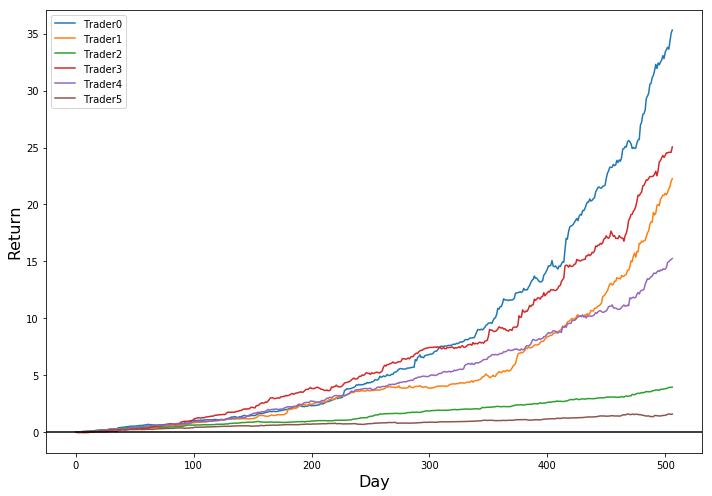

In [661]:
# Plot training results

plot_list = [[predictions_train_AAPL_MSFT, actuals_train_AAPL_MSFT],
             [predictions_train_SLB_HAL, actuals_train_SLB_HAL],
             [predictions_train_BAC_C, actuals_train_BAC_C],
             [predictions_train_AAL_UAL, actuals_train_AAL_UAL],
             [predictions_train_F_GM, actuals_train_F_GM],
             [predictions_train_GS_JPM, actuals_train_GS_JPM]
            ]

fig, ax = plt.subplots(figsize=(10,7))
train_results = pd.DataFrame()

for index, obj in enumerate(plot_list):
    predictions_train = obj[0]
    actuals_train = obj[1]

    init = 100
    position_train = []
    for i, val in enumerate(list(predictions_train)):
        if val >= 0:
            position_train.append(1)
        else:
            position_train.append(-1)
    train_result = np.array(position_train)*actuals_train
    train_results['Trader' + str(index)] = train_result
    cum_returns = np.cumprod(train_result+1)-1
    cum_returns = np.append([0], cum_returns)
    plt.plot(cum_returns, label=train_results.columns[index]);
        
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.legend()
plt.tight_layout()
plt.axhline(y=0, color='black');
plt.savefig(fname='train_returns', dpi=150)
plt.show()

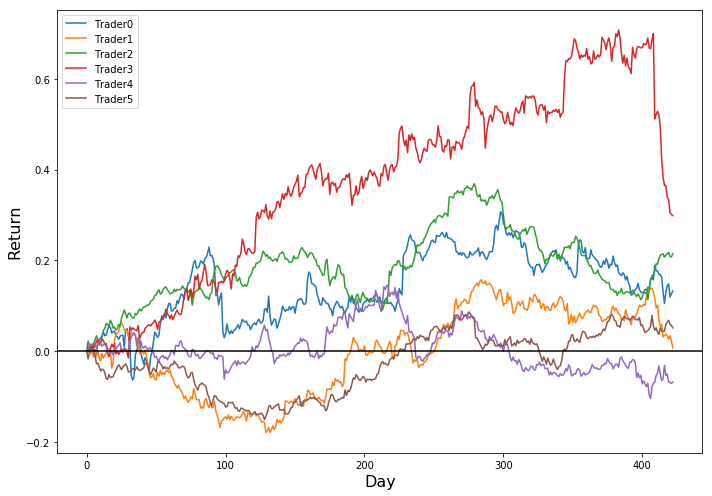

In [662]:
# Plot test results

plot_list = [[predictions_test_AAPL_MSFT, actuals_test_AAPL_MSFT],
             [predictions_test_SLB_HAL, actuals_test_SLB_HAL],
             [predictions_test_BAC_C, actuals_test_BAC_C],
             [predictions_test_AAL_UAL, actuals_test_AAL_UAL],
             [predictions_test_F_GM, actuals_test_F_GM],
             [predictions_test_GS_JPM, actuals_test_GS_JPM]
            ]

fig, ax = plt.subplots(figsize=(10,7))
test_results = pd.DataFrame()

for index, obj in enumerate(plot_list):
    predictions_test = obj[0]
    actuals_test = obj[1]

    init = 100
    position_test = []
    for i, val in enumerate(list(predictions_test)):
        if val >= 0:
            position_test.append(1)
        else:
            position_test.append(-1)
    test_result = np.array(position_test)*actuals_test
    test_results['Trader' + str(index)] = test_result
    cum_returns = np.cumprod(test_result+1)-1
    cum_returns = np.append([0], cum_returns)
    plt.plot(cum_returns, label=test_results.columns[index]);

ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.legend()
plt.tight_layout()
plt.axhline(y=0, color='black');
plt.savefig(fname='test_returns', dpi=150)
plt.show()

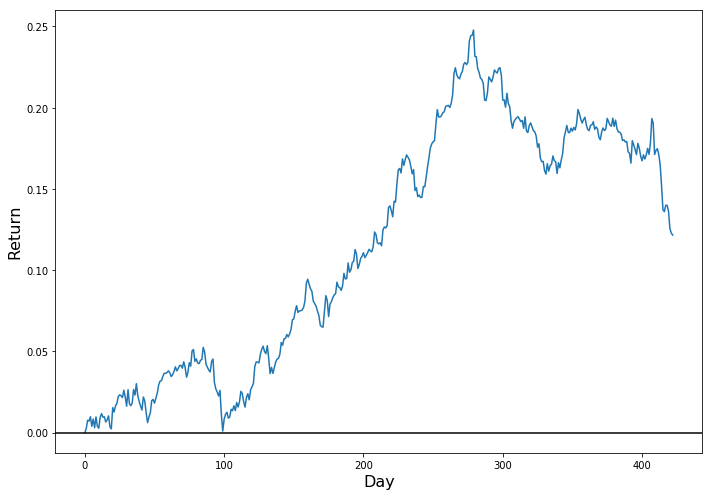

In [663]:
# Equal weight backtest for test period

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(np.append(0, np.cumprod(1 + np.mean(test_results, axis=1)) - 1))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.tight_layout()
plt.axhline(y=0, color='black');
plt.savefig(fname='test_port_returns', dpi=150)
plt.show()

In [664]:
train_results.corr()

Trader0   Trader1   Trader2   Trader3   Trader4   Trader5
Trader0  1.000000  0.028813  0.020585  0.165498  0.009895 -0.039277
Trader1  0.028813  1.000000  0.053907 -0.045322  0.038276 -0.047471
Trader2  0.020585  0.053907  1.000000 -0.091777  0.025242  0.120793
Trader3  0.165498 -0.045322 -0.091777  1.000000 -0.035776  0.014938
Trader4  0.009895  0.038276  0.025242 -0.035776  1.000000  0.022011
Trader5 -0.039277 -0.047471  0.120793  0.014938  0.022011  1.000000

In [665]:
test_results.corr()

Trader0   Trader1   Trader2   Trader3   Trader4   Trader5
Trader0  1.000000  0.024515 -0.039022 -0.050126 -0.054589 -0.013564
Trader1  0.024515  1.000000 -0.058490  0.029198  0.046085  0.113595
Trader2 -0.039022 -0.058490  1.000000  0.049587 -0.007225 -0.021897
Trader3 -0.050126  0.029198  0.049587  1.000000  0.067549  0.011728
Trader4 -0.054589  0.046085 -0.007225  0.067549  1.000000 -0.061606
Trader5 -0.013564  0.113595 -0.021897  0.011728 -0.061606  1.000000

In [666]:
# Summary Table of Test Results

port_results = np.mean(test_results, axis=1)
ret_port = (1 + np.mean(port_results))**252 - 1
risk_port = np.std(port_results)*(252**0.5)
sharpe_port = ret_port/risk_port

print('Return: ' + str(round(ret_port,3)))
print('Risk: ' + str(round(risk_port,3)))
print('Sharpe Ratio: ' + str(round(sharpe_port,3)))

Return: 0.074
Risk: 0.07
Sharpe Ratio: 1.048


In [667]:
# Pickle the results
import pickle

file = open('actor_bday_v1.0', 'wb')
pickle.dump(train_results, file)
file.close()

file = open('actor_bday_v1.0', 'wb')
pickle.dump(test_results, file)
file.close()

model_AAPL_MSFT.save('model_AAPL_MSFT.h5')
model_GS_JPM.save('model_GS_JPM.h5')
model_SLB_HAL.save('model_SLB_HAL.h5')
model_XOM_CVX.save('model_XOM_CVX.h5')
model_BAC_C.save('model_BAC_C.h5')
model_KO_PEP.save('model_KO_PEP.h5')
model_AAL_UAL.save('model_AAL_UAL.h5')
model_F_GM.save('model_F_GM.h5')

In [668]:
# Create the manager using an XG Boosted Tree
import xgboost as xgb

xg_train_len = 250

In [726]:
def make_xg_tree(xg_tree_func, trader_results, lags_tree):
    xg_in_X, xg_in_Y, features_xgb = make_variables(np.matrix(trader_results).T, lags_tree, 0, 1)
    xg_in_X = xg_in_X.reshape((xg_in_X.shape[0], xg_in_X.shape[2]))
    xg_in_Y_class = []
    for i in xg_in_Y:
        if i > 0:
            xg_in_Y_class.append(1)
        else:
            xg_in_Y_class.append(0)

    xg_tree_func.fit(xg_in_X[:xg_train_len], xg_in_Y_class[:xg_train_len])

    xg_predictions_train = xg_tree_func.predict_proba(xg_in_X[:xg_train_len])
    xg_predictions_test = xg_tree_func.predict_proba(xg_in_X[xg_train_len:])
    
    return xg_tree_func, xg_predictions_test, xg_predictions_train, xg_in_X, xg_in_Y_class, xg_in_Y

In [727]:
lags_tree = 6

xg_tree0 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 1000)
xg_tree0, xg_predictions_test0, xg_predictions_train0, xg_in_X0, xg_in_Y_class0, xg_in_Y0 = make_xg_tree(xg_tree0, test_results['Trader0'], lags_tree)


xg_tree1 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 1000)
xg_tree1, xg_predictions_test1, xg_predictions_train1, xg_in_X1, xg_in_Y_class1, xg_in_Y1 = make_xg_tree(xg_tree1, test_results['Trader1'], lags_tree)


xg_tree2 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 1000)
xg_tree2, xg_predictions_test2, xg_predictions_train2, xg_in_X2, xg_in_Y_class2, xg_in_Y2 = make_xg_tree(xg_tree2, test_results['Trader2'], lags_tree)


xg_tree3 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 1000)
xg_tree3, xg_predictions_test3, xg_predictions_train3, xg_in_X3, xg_in_Y_class3, xg_in_Y3 = make_xg_tree(xg_tree3, test_results['Trader3'], lags_tree)


xg_tree4 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 1000)
xg_tree4, xg_predictions_test4, xg_predictions_train4, xg_in_X4, xg_in_Y_class4, xg_in_Y4 = make_xg_tree(xg_tree4, test_results['Trader4'], lags_tree)


xg_tree5 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 1000)
xg_tree5, xg_predictions_test5, xg_predictions_train5, xg_in_X5, xg_in_Y_class5, xg_in_Y5 = make_xg_tree(xg_tree5, test_results['Trader5'], lags_tree)

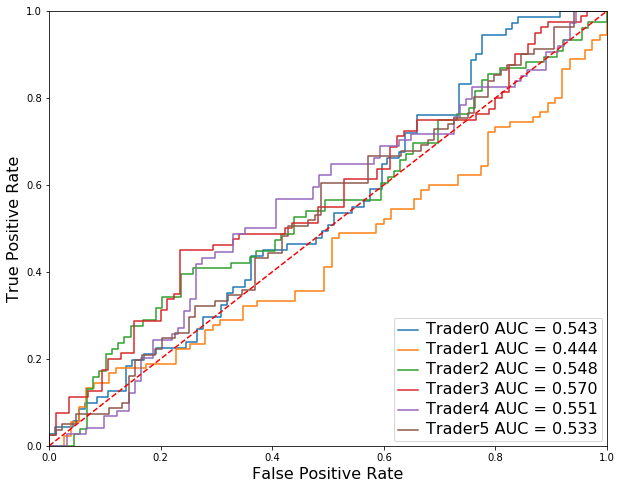

In [763]:
import sklearn.metrics as metrics

cutoff = 0.7

model_list = [xg_tree0, xg_tree1, xg_tree2 ,xg_tree3 ,xg_tree4, xg_tree5]
model_name = ['Trader0', 'Trader1', 'Trader2', 'Trader3', 'Trader4', 'Trader5']
y_vals = [xg_in_Y_class0, xg_in_Y_class1, xg_in_Y_class2, xg_in_Y_class3, xg_in_Y_class4, xg_in_Y_class5]
y_rets = [xg_in_Y0, xg_in_Y1, xg_in_Y2, xg_in_Y3, xg_in_Y4, xg_in_Y5]
x_vals = [xg_in_X0, xg_in_X1, xg_in_X2, xg_in_X3, xg_in_X4, xg_in_X5]

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
p_and_l = []

for i, model in enumerate(model_list):
    y_val = y_vals[i][xg_train_len:]
    y_ret = y_rets[i][xg_train_len:]
    y_pred = list(model.predict_proba(x_vals[i][xg_train_len:])[:,1])
    y_pred_class = []
    for p in y_pred:
        if p > cutoff:
            y_pred_class.append(1)
        else:
            y_pred_class.append(0)
    p_and_l.append(np.array(y_pred_class).reshape((-1,1))*np.array(y_ret).reshape((-1,1)))
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.savefig(fname='PM_ROC_Curve', dpi=150)
plt.show()

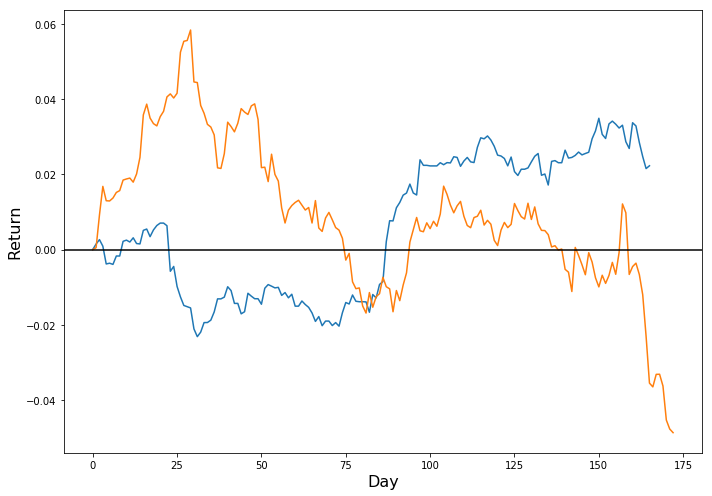

In [764]:
# Calculate backtest with risk managers

p_and_l_mat = p_and_l[0]
for i in p_and_l[1:]:
    p_and_l_mat = np.append(p_and_l_mat, i, axis=1)

# Equal weight backtest for test period
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(np.append(0, np.cumprod(1 + np.mean(p_and_l_mat, axis=1)) - 1))
plt.plot(np.append(0, np.cumprod(1 + np.mean(test_results[xg_train_len:], axis=1)) - 1))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.tight_layout()
plt.axhline(y=0, color='black');
plt.show()

In [ ]:
# True Test